# TabTransformer++ for Residual Learning

> **Based on the original TabTransformer paper:**
> 
> Huang, X., Khetan, A., Cvitkovic, M., & Karnin, Z. (2020). *TabTransformer: Tabular Data Modeling Using Contextual Embeddings*. arXiv:2012.06678
> 
> 📄 [arXiv Paper](https://arxiv.org/abs/2012.06678) | 🔗 [GitHub](https://github.com/lucidrains/tab-transformer-pytorch)

This notebook extends the TabTransformer architecture with additional innovations for **residual learning**. The key idea is:

1. Train a simple "base" model (HistGradientBoostingRegressor) to make initial predictions
2. Train a TabTransformer to predict the **residuals** (errors) of the base model
3. Combine: `Final Prediction = Base Prediction + Predicted Residual`

This stacking technique often yields better results than either model alone.

## Key Components
- **Quantile Binning**: Converts continuous features into discrete tokens
- **Gated Fusion**: Learns to balance binned tokens with raw scalar values *(novel extension)*
- **EMA (Exponential Moving Average)**: Polyak averaging for more stable predictions
- **Isotonic Calibration**: Post-processing to improve residual predictions

## 1. Setup & Configuration

Import required libraries and define hyperparameters:

- **Feature Engineering**: Number of bins for quantile discretization
- **Model Architecture**: Embedding dimensions, attention heads, transformer layers
- **Training**: Learning rate, batch size, EMA decay for Polyak averaging

In [7]:
!pip install numpy pandas matplotlib scikit-learn torch 

In [8]:
import os
import gc
import time
import warnings
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import root_mean_squared_error

warnings.filterwarnings("ignore")
pd.set_option("mode.copy_on_write", True)

# =============================================================================
# Configuration - TabTransformer++ Hyperparameters
# =============================================================================
class Config:
    SEED            = 2025
    
    # --- Quantile Binning (Tokenization) ---
    NBINS           = 32        # Bins for raw numeric features
    NBINS_BASE      = 128       # Finer bins for base model predictions
    NBINS_DT        = 64        # Bins for tree model predictions
    
    # --- TabTransformer++ Architecture ---
    EMB_DIM         = 64        # Embedding dimension (d_model)
    N_HEADS         = 4         # Multi-head attention heads
    N_LAYERS        = 3         # Transformer encoder layers
    MLP_HID         = 192       # Prediction head hidden dimension
    DROPOUT         = 0.1       # Attention & feedforward dropout
    EMB_DROPOUT     = 0.05      # Post-embedding dropout
    TOKENDROP_P     = 0.12      # TokenDrop regularization probability
    
    # --- Training ---
    EPOCHS          = 10        # Training epochs (shortened for demo)
    BATCH_SIZE      = 1024
    LR              = 2e-3      # AdamW learning rate
    WEIGHT_DECAY    = 1e-5      # L2 regularization
    EMA_DECAY       = 0.995     # Exponential Moving Average (Polyak averaging)
    DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

def seed_everything(seed):
    """Set random seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

seed_everything(Config.SEED)
print(f"Running on {Config.DEVICE}")

Running on cpu


## 2. Data Simulation: Building the "Stack"

This section simulates a real-world stacking scenario:

1. **Load Data**: California Housing dataset (predicting median house values)
2. **Train Base Models** using K-Fold cross-validation:
   - `HistGradientBoostingRegressor` → generates `base_pred` (captures non-linear patterns)
   - `RandomForest` → generates `dt_pred` (provides additional signal)
3. **Calculate Residuals**: `residual = target - base_pred`
   - This is what the TabTransformer will learn to predict

**Why HistGradientBoostingRegressor instead of Ridge?**
- Ridge (linear) leaves non-linear patterns in residuals
- HGBR captures non-linearity, so the Transformer focuses on high-order feature interactions
- This cleaner residual signal improves transformer learning

The out-of-fold (OOF) predictions prevent data leakage.

In [9]:
def get_simulated_data():
    """
    Simulate a model stacking scenario for residual learning.
    
    Steps:
        1. Load California Housing dataset
        2. Train base models (HistGradientBoosting, RandomForest) with K-Fold CV
        3. Generate out-of-fold (OOF) predictions to avoid leakage
        4. Calculate residuals: target - base_prediction
    
    Returns:
        train_df: Training data with base_pred, dt_pred, residual columns
        test_df: Test data with base_pred, dt_pred columns
        features: List of original feature column names
    """
    import tarfile
    import tempfile
    import urllib.request
    from pathlib import Path
    
    print("\n--- 1. Simulating Base & DT Models (The 'Stack') ---")
    
    # California Housing dataset - download manually if sklearn fails
    sklearn_data_home = Path.home() / "scikit_learn_data"
    cal_housing_dir = sklearn_data_home / "cal_housing"
    cal_housing_file = cal_housing_dir / "cal_housing.pkz"
    
    # Try sklearn first, fall back to manual download
    try:
        data = fetch_california_housing(as_frame=True)
    except Exception as e:
        print(f"sklearn download failed ({e}), fetching from alternate source...")
        # Download from a mirror/alternate source
        url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
        
        req = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
        with urllib.request.urlopen(req) as response:
            import io
            csv_content = response.read().decode('utf-8')
            housing_df = pd.read_csv(io.StringIO(csv_content))
        
        # This dataset has different columns, map to California Housing format
        # The Ageron dataset has: longitude,latitude,housing_median_age,total_rooms,
        # total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
        housing_df = housing_df.dropna()
        
        # Create feature columns matching California Housing
        feature_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
        target_col = 'MedHouseVal'
        
        df = pd.DataFrame()
        df['MedInc'] = housing_df['median_income']
        df['HouseAge'] = housing_df['housing_median_age']
        df['AveRooms'] = housing_df['total_rooms'] / housing_df['households']
        df['AveBedrms'] = housing_df['total_bedrooms'] / housing_df['households']
        df['Population'] = housing_df['population']
        df['AveOccup'] = housing_df['population'] / housing_df['households']
        df['Latitude'] = housing_df['latitude']
        df['Longitude'] = housing_df['longitude']
        df['MedHouseVal'] = housing_df['median_house_value'] / 100000  # Scale to match original
        
        print(f"Loaded {len(df)} samples from alternate source")
        target_col = "MedHouseVal"
    else:
        df = data.frame
        target_col = "MedHouseVal"
    
    # Hold out 20% as test set (simulates private leaderboard)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=Config.SEED)
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    
    # Initialize prediction columns
    train_df["base_pred"] = 0.0
    train_df["dt_pred"] = 0.0
    train_df["fold"] = -1
    
    # K-Fold for leak-free OOF predictions
    kf = KFold(n_splits=5, shuffle=True, random_state=Config.SEED)
    
    # Base models for the stack
    # Using HistGradientBoostingRegressor instead of Ridge:
    # - Captures non-linear patterns that Ridge misses
    # - Leaves purer high-order interactions for the Transformer
    # - Faster than RandomForest due to histogram-based splits
    model_base = HistGradientBoostingRegressor(
        max_iter=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=Config.SEED
    )
    model_dt = RandomForestRegressor(n_estimators=20, max_depth=8, n_jobs=-1, random_state=Config.SEED)
    
    print("Generating OOF predictions...")
    for fold, (tr_idx, val_idx) in enumerate(kf.split(train_df)):
        X_tr = train_df.loc[tr_idx].drop(columns=[target_col, "base_pred", "dt_pred", "fold"])
        y_tr = train_df.loc[tr_idx, target_col]
        X_val = train_df.loc[val_idx].drop(columns=[target_col, "base_pred", "dt_pred", "fold"])
        
        # HistGradientBoosting (base model)
        model_base.fit(X_tr, y_tr)
        train_df.loc[val_idx, "base_pred"] = model_base.predict(X_val)
        
        # Random Forest (tree-based model)
        model_dt.fit(X_tr, y_tr)
        train_df.loc[val_idx, "dt_pred"] = model_dt.predict(X_val)
        
        train_df.loc[val_idx, "fold"] = fold

    # Generate test predictions (trained on full training set)
    print("Generating Test predictions...")
    X_full = train_df.drop(columns=[target_col, "base_pred", "dt_pred", "fold"])
    y_full = train_df[target_col]
    X_test = test_df.drop(columns=[target_col])
    
    model_base.fit(X_full, y_full)
    test_df["base_pred"] = model_base.predict(X_test)
    
    model_dt.fit(X_full, y_full)
    test_df["dt_pred"] = model_dt.predict(X_test)
    
    # Calculate residuals - this is what TabTransformer++ will predict
    train_df["residual"] = train_df[target_col] - train_df["base_pred"]
    
    # Extract original feature names
    features = [c for c in train_df.columns if c not in [target_col, "base_pred", "dt_pred", "fold", "residual"]]
    
    base_rmse = root_mean_squared_error(train_df[target_col], train_df['base_pred'])
    print(f"Base Model RMSE (Train OOF): {base_rmse:.4f}")
    
    return train_df, test_df, features

# Run simulation
train_df, test_df, features = get_simulated_data()


--- 1. Simulating Base & DT Models (The 'Stack') ---
sklearn download failed (HTTP Error 403: Forbidden), fetching from alternate source...
Loaded 20433 samples from alternate source
Generating OOF predictions...
Generating Test predictions...
Base Model RMSE (Train OOF): 0.4873


## 3. Tabular Tokenizer

The `TabularTokenizer` prepares data for the transformer:

### Quantile Binning (Discretization)
- Converts continuous features into discrete "tokens" (like words in NLP)
- Uses quantile-based bins so each bin has roughly equal samples
- Different bin counts for features (32), base predictions (128), and tree predictions (64)

### Robust Scaling (Outlier-Resistant Normalization)
- Standardizes raw values using: `(x - median) / IQR`
- Uses **median** instead of mean, and **IQR** (Interquartile Range) instead of std
- This is **critical for stability**: Z-Score `(x - mean) / std` is sensitive to outliers
- Outliers can cause gradient explosions in the scalar path, leading to fold anomalies

- Robust scaling stabilizes training and reduces variance across foldsThis dual representation (tokens + scalars) gives the model both discrete patterns and continuous precision.


In [10]:
class TabularTokenizer:
    """
    Dual-representation tokenizer for TabTransformer++.
    
    Creates two representations per feature:
        1. Token IDs: Quantile bin indices (discrete)
        2. Scalar values: Robust-scaled (continuous) using (x - median) / IQR
    
    Uses ROBUST SCALING instead of Z-Score to handle outliers:
        - Z-Score (x - mean) / std is sensitive to outliers
        - Robust scaling (x - median) / IQR is resistant to outliers
        - This prevents gradient explosions from extreme values
        - Critical for training stability across all folds
    """
    def __init__(self, cols):
        self.cols = cols
        self.edges = {}   # Quantile bin edges per feature
        self.stats = {}   # (median, IQR) for robust scaling
        
    def _make_edges(self, x, nbins):
        """Compute quantile-based bin edges."""
        x = x[np.isfinite(x)]
        if len(x) == 0: 
            return np.array([0.0, 1.0])
        qs = np.linspace(0.0, 1.0, nbins + 1)
        edges = np.unique(np.quantile(x, qs))
        if len(edges) < 2: 
            edges = np.array([x.min(), x.max() + 1e-6])
        return edges
    
    def _compute_robust_stats(self, x):
        """Compute robust statistics: median and IQR (Interquartile Range)."""
        x = x[np.isfinite(x)]
        median = np.median(x)
        q25, q75 = np.percentile(x, [25, 75])
        iqr = q75 - q25
        # Prevent division by zero; fallback to std if IQR is 0
        if iqr < 1e-8:
            iqr = np.std(x) + 1e-8
        return (median, iqr)

    def fit(self, df):
        """Fit tokenizer on training data only (leak-free)."""
        # Original features - use ROBUST SCALING
        for c in self.cols:
            self.edges[c] = self._make_edges(df[c].values, Config.NBINS)
            self.stats[c] = self._compute_robust_stats(df[c].values)
            
        # Base model predictions (finer bins for precision)
        self.edges["_base_"] = self._make_edges(df["base_pred"].values, Config.NBINS_BASE)
        self.stats["_base_"] = self._compute_robust_stats(df["base_pred"].values)
        
        # Tree model predictions
        self.edges["_dt_"] = self._make_edges(df["dt_pred"].values, Config.NBINS_DT)
        self.stats["_dt_"] = self._compute_robust_stats(df["dt_pred"].values)
        
        # Target (residual) statistics for robust scaling
        self.stats["_target_"] = self._compute_robust_stats(df["residual"].values)

    def transform(self, df):
        """
        Transform data to dual representation.
        
        Returns:
            toks: Token IDs [N, T] - discrete bin indices
            vals: Scalar values [N, T] - robust-scaled (outlier resistant)
        """
        N = len(df)
        T = len(self.cols) + 2  # features + base_pred + dt_pred
        
        toks = np.zeros((N, T), dtype=np.int64)
        vals = np.zeros((N, T), dtype=np.float32)
        
        def _process_column(col_name, edge_key, stat_key, out_idx):
            v = df[col_name].values
            # Discretize: assign to quantile bins
            idx = np.searchsorted(self.edges[edge_key], v, side="right") - 1
            toks[:, out_idx] = np.clip(idx, 0, len(self.edges[edge_key]) - 2)
            # Normalize: ROBUST scaling (x - median) / IQR
            median, iqr = self.stats[stat_key]
            vals[:, out_idx] = (v - median) / iqr

        # Process original features
        for i, c in enumerate(self.cols):
            _process_column(c, c, c, i)
            
        # Process stacked predictions (base & tree models)
        _process_column("base_pred", "_base_", "_base_", T - 2)
        _process_column("dt_pred", "_dt_", "_dt_", T - 1)
        
        return toks, vals
    
    def get_vocab_sizes(self):
        """Get vocabulary size for each feature's embedding layer."""
        sizes = [len(self.edges[c]) - 1 for c in self.cols]
        sizes.append(len(self.edges["_base_"]) - 1)
        sizes.append(len(self.edges["_dt_"]) - 1)
        return sizes

## 4. Model Architecture

### TabTransformerGated — Architectural Innovations

This implementation extends the original TabTransformer with several key innovations for tabular data:

---

### 🔷 Innovation 1: Dual Representation (Tokens + Scalars)

Unlike standard transformers that use only discrete tokens, we maintain **both representations**:

| Representation | How it's Created | What it Captures |
|----------------|------------------|------------------|
| **Token Embedding** | Quantile bin → learned embedding | Discrete patterns, ordinal relationships |
| **Value Embedding** | Raw scalar → MLP projection | Precise numeric magnitude |

**Why both?** Binning loses precision (e.g., 1.01 and 1.99 might share a bin), but raw scalars lack the pattern-matching power of embeddings.

---

### 🔷 Innovation 2: Learnable Gated Fusion (Safe Initialization)

Each feature has a **learnable gate** (initialized to **-2.0**) that controls the blend:

```
final_embedding[i] = token_emb[i] + σ(gate[i]) × value_emb[i]
```

- `σ(gate)` is a sigmoid, so fusion weight is in [0, 1]
- **Gate = -2.0 → σ ≈ 0.12**: Model starts by relying on stable token embeddings
- **Gate = 0 → σ = 0.5**: Equal weight (but can cause early divergence)
- **Gate > 0 → σ > 0.5**: Model relies more on continuous values

**Why -2.0?** Initializing at 0 gives 50% scalar reliance from the start, which can cause
instability if scalar values have outliers. Starting at -2.0 (12% scalar) lets the model
learn to trust scalars gradually, preventing fold anomalies.

---

### 🔷 Innovation 3: Per-Token Value MLPs

Instead of a single shared MLP for all features, each feature gets its **own projection network**:

```python
PerTokenValMLP: Linear(1 → 64) → GELU → Linear(64 → 64) → LayerNorm
```

This allows different features to learn different transformations (e.g., log-like for skewed features, linear for normal ones).

---

### 🔷 Innovation 4: TokenDrop Regularization (with Inverted Scaling)

During training, we randomly **zero out** feature embeddings with probability `p=0.12`:

```python
mask = (random > p)  # per-sample, per-feature
mask[:, 0] = 1.0     # Never drop CLS token
x = x * mask / (1 - p)  # Scale to maintain expected magnitude
```

Benefits:
- Forces model to not over-rely on any single feature
- Similar to dropout but at the feature level
- Improves generalization on tabular data

**Important**: We scale remaining tokens by `1/(1-p)` during training (inverted dropout).
This maintains consistent expected values between train and test modes.

---

### 🔷 Innovation 5: CLS Token Aggregation

Following BERT's approach, we prepend a special `[CLS]` token:

```
Input:  [CLS, feat_1, feat_2, ..., feat_n, base_pred, dt_pred]
Output: Use CLS embedding for final prediction
```

The transformer's self-attention allows CLS to attend to all features and learn a global representation.

---

### 🔷 Innovation 6: Pre-LayerNorm Transformer

We use `norm_first=True` (Pre-LN) instead of Post-LN:

```
Pre-LN:  x = x + Attention(LayerNorm(x))
Post-LN: x = LayerNorm(x + Attention(x))
```

Pre-LN is more stable for training and doesn't require careful learning rate warmup.

---

### Full Architecture Summary

```
Input: (tokens, values) for each of T features
         ↓
┌─────────────────────────────────────────┐
│  Per-Feature Processing (for i in T):  │
│    token_emb = Embedding(token[i])      │
│    value_emb = MLP(value[i])            │
│    gate = sigmoid(learnable_param[i])   │
│    feat[i] = token_emb + gate*value_emb │
└─────────────────────────────────────────┘
         ↓
    Embedding Dropout (p=0.05)
         ↓
    Prepend [CLS] token
         ↓
    TokenDrop (p=0.12, training only, scaled by 1/(1-p))
         ↓
┌─────────────────────────────────────────┐
│  Transformer Encoder (3 layers):        │
│    - 4 attention heads                  │
│    - dim=64, feedforward=256            │
│    - Pre-LayerNorm, GELU activation     │
└─────────────────────────────────────────┘
         ↓
    Extract [CLS] embedding
         ↓
┌─────────────────────────────────────────┐
│  Prediction Head:                       │
│    LayerNorm → Linear(64→192) → GELU    │
│    → Dropout → Linear(192→1)            │
└─────────────────────────────────────────┘
         ↓
    Output: Predicted Residual (robust-scaled)
```

In [11]:
class TokenDrop(nn.Module):
    """
    Feature-level dropout regularization (Innovation #4).
    
    Randomly zeros out feature embeddings during training to prevent
    over-reliance on any single feature. CLS token is never dropped.
    
    IMPORTANT: Scales remaining tokens by 1/(1-p) during training to maintain
    expected magnitude, similar to standard Dropout. This prevents magnitude
    shift between train and test modes.
    """
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        # x: [B, 1+T, D] where first token is CLS
        if not self.training or self.p <= 0: 
            return x
        mask = (torch.rand(x.shape[0], x.shape[1], 1, device=x.device) > self.p).float()
        mask[:, 0, :] = 1.0  # Preserve CLS token
        # Scale by 1/(1-p) to maintain expected magnitude during training
        # This ensures train-test consistency (like standard Dropout)
        return x * mask / (1.0 - self.p)


class PerTokenValMLP(nn.Module):
    """
    Per-feature value projection network (Innovation #3).
    
    Each feature gets its own MLP to project scalar values to embedding space.
    This allows different features to learn different transformations.
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.LayerNorm(emb_dim)
        )
        
    def forward(self, x): 
        return self.net(x)


class TabTransformerGated(nn.Module):
    """
    TabTransformer++ with Gated Fusion.
    
    Key architectural innovations:
        1. Dual representation (tokens + scalars)
        2. Learnable per-feature gates for fusion (safe initialization at -2.0)
        3. Per-token value MLPs
        4. TokenDrop regularization (with inverted scaling)
        5. CLS token for aggregation
        6. Pre-LayerNorm transformer (norm_first=True)
    """
    def __init__(self, vocab_sizes):
        super().__init__()
        self.num_tokens = len(vocab_sizes)
        
        # Innovation #1: Token embeddings (discrete representation)
        self.embs = nn.ModuleList([
            nn.Embedding(v + 1, Config.EMB_DIM) for v in vocab_sizes
        ])
        
        # Innovation #3: Per-feature value MLPs (continuous representation)
        self.val_mlps = nn.ModuleList([
            PerTokenValMLP(Config.EMB_DIM) for _ in vocab_sizes
        ])
        
        # Innovation #2: Learnable gates for fusion
        # SAFE INITIALIZATION: Start at -2.0 (sigmoid ≈ 0.12) instead of 0 (sigmoid = 0.5)
        # This biases the model to rely on stable token embeddings first,
        # preventing early divergence before it learns to use scalar values.
        # As training progresses, gates can learn to increase scalar reliance.
        self.gates = nn.ParameterList([
            nn.Parameter(torch.tensor([-2.0])) for _ in vocab_sizes
        ])
        self.sigmoid = nn.Sigmoid()
        
        # Innovation #5: CLS token for global aggregation
        self.cls_token = nn.Parameter(torch.zeros(1, 1, Config.EMB_DIM))
        self.emb_dropout = nn.Dropout(Config.EMB_DROPOUT)
        
        # Innovation #4: TokenDrop regularization
        self.tokendrop = TokenDrop(Config.TOKENDROP_P)
        
        # Innovation #6: Pre-LayerNorm Transformer (stable training)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=Config.EMB_DIM, 
            nhead=Config.N_HEADS, 
            dim_feedforward=Config.EMB_DIM * 4,
            dropout=Config.DROPOUT, 
            batch_first=True, 
            norm_first=True,  # Pre-LN for stability
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=Config.N_LAYERS)
        
        # Prediction head
        self.head = nn.Sequential(
            nn.LayerNorm(Config.EMB_DIM),
            nn.Linear(Config.EMB_DIM, Config.MLP_HID),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.MLP_HID, 1)
        )
        
    def forward(self, x_tok, x_val):
        B = x_tok.shape[0]
        
        # Gated Fusion: embedding[i] = token_emb + sigmoid(gate) * value_emb
        emb_list = []
        for i in range(self.num_tokens):
            tok_e = self.embs[i](x_tok[:, i])           # Discrete embedding
            val_e = self.val_mlps[i](x_val[:, i:i+1])   # Continuous embedding
            g = self.sigmoid(self.gates[i])             # Learnable blend weight
            emb_list.append(tok_e + g * val_e)
            
        x = torch.stack(emb_list, dim=1)  # [B, T, D]
        x = self.emb_dropout(x)
        
        # Prepend CLS token for global aggregation
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, x], dim=1)  # [B, 1+T, D]
        
        # Apply TokenDrop and Transformer encoder
        x = self.tokendrop(x)
        x = self.encoder(x)
        
        # Extract CLS embedding for prediction
        return self.head(x[:, 0, :]).squeeze(-1)


class TTDataset(Dataset):
    """PyTorch Dataset for TabTransformer++ dual-representation data."""
    def __init__(self, toks, vals, y=None):
        self.toks = torch.as_tensor(toks, dtype=torch.long)
        self.vals = torch.as_tensor(vals, dtype=torch.float32)
        self.y = torch.as_tensor(y, dtype=torch.float32) if y is not None else None
        
    def __len__(self): 
        return len(self.toks)
    
    def __getitem__(self, i): 
        return (self.toks[i], self.vals[i]), (self.y[i] if self.y is not None else 0.0)

## 5. Training Loop

### Cross-Validation Strategy
For each of the 5 folds:

1. **Leak-Free Tokenization**: Fit tokenizer only on training data
2. **Z-Score Targets**: Normalize residuals for stable training
3. **Train with EMA**: 
   - Main model learns via gradient descent
   - EMA model maintains exponential moving average of weights (Polyak averaging)
   - EMA often generalizes better than the final trained weights

### Isotonic Calibration
After training, we calibrate predictions using **Isotonic Regression**:
- Maps the model's z-scored outputs back to actual residual values
- Monotonic transformation that can correct systematic biases
- Fitted on validation data, then applied to test predictions

### Final Prediction
```
final_prediction = base_pred + calibrated_residual
```

In [12]:
# =============================================================================
# Training Loop with K-Fold Cross-Validation
# =============================================================================

# Storage for predictions
oof_preds = np.zeros(len(train_df))        # Out-of-fold residual predictions
test_preds_accum = np.zeros(len(test_df))  # Averaged test predictions

folds = sorted(train_df["fold"].unique())
print(f"\n--- 2. Training TabTransformer++ for Residual Learning ({len(folds)} folds) ---")

for k in folds:
    # =========================================================================
    # A. Leak-Free Data Preparation
    # =========================================================================
    tr_mask = train_df["fold"] != k
    va_mask = train_df["fold"] == k
    
    # Fit tokenizer on training fold only (prevents data leakage)
    tokenizer = TabularTokenizer(features)
    tokenizer.fit(train_df[tr_mask])
    
    # Transform to dual representation (tokens + scalars)
    X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
    X_va_tok, X_va_val = tokenizer.transform(train_df[va_mask])
    X_te_tok, X_te_val = tokenizer.transform(test_df)
    
    # Z-score normalize targets for stable training
    y_mu, y_std = tokenizer.stats["_target_"]
    y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
    y_va_raw = train_df.loc[va_mask, "residual"].values
    
    # =========================================================================
    # B. Create DataLoaders
    # =========================================================================
    dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                       batch_size=Config.BATCH_SIZE, shuffle=True)
    dl_va = DataLoader(TTDataset(X_va_tok, X_va_val), 
                       batch_size=Config.BATCH_SIZE, shuffle=False)
    dl_te = DataLoader(TTDataset(X_te_tok, X_te_val), 
                       batch_size=Config.BATCH_SIZE, shuffle=False)
    
    # =========================================================================
    # C. Initialize Models (Main + EMA for Polyak Averaging)
    # =========================================================================
    model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
    ema_model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
    ema_model.load_state_dict(model.state_dict())
    
    opt = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
    loss_fn = nn.SmoothL1Loss(beta=1.0)  # Huber loss for robustness
    
    # =========================================================================
    # D. Training Loop with EMA Updates
    # =========================================================================
    for epoch in range(Config.EPOCHS):
        model.train()
        for (xt, xv), y in dl_tr:
            xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
            
            opt.zero_grad()
            pred = model(xt, xv)
            loss = loss_fn(pred, y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()
            
            # Update EMA model (Polyak averaging for better generalization)
            with torch.no_grad():
                for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                    ema_p.data.mul_(Config.EMA_DECAY).add_(p.data, alpha=1 - Config.EMA_DECAY)
    
    # =========================================================================
    # E. Evaluation with Isotonic Calibration
    # =========================================================================
    ema_model.eval()
    
    # Predict validation set (in z-score space)
    preds_z = []
    with torch.no_grad():
        for (xt, xv), _ in dl_va:
            preds_z.append(ema_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
    preds_z = np.concatenate(preds_z)
    
    # Isotonic calibration: map z-scored predictions to actual residuals
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(preds_z, y_va_raw)
    calib_preds = iso.predict(preds_z)
    
    oof_preds[va_mask] = calib_preds
    rmse = root_mean_squared_error(y_va_raw, calib_preds)
    print(f"Fold {k} | Residual RMSE: {rmse:.4f}")
    
    # Apply calibration to test predictions
    preds_te_z = []
    with torch.no_grad():
        for (xt, xv), _ in dl_te:
            preds_te_z.append(ema_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
    preds_te_z = np.concatenate(preds_te_z)
    test_preds_accum += iso.predict(preds_te_z) / len(folds)  # Average across folds
    
    # Cleanup
    del model, ema_model, opt, dl_tr
    if Config.DEVICE == "cuda": 
        torch.cuda.empty_cache()

# =============================================================================
# Final Results: Base + Predicted Residual
# =============================================================================
final_oof = train_df["base_pred"] + oof_preds
final_test = test_df["base_pred"] + test_preds_accum

base_cv = root_mean_squared_error(train_df["MedHouseVal"], train_df["base_pred"])
tt_cv = root_mean_squared_error(train_df["MedHouseVal"], final_oof)

base_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"])
tt_test = root_mean_squared_error(test_df["MedHouseVal"], final_test)

print("\n" + "=" * 50)
print("FINAL RESULTS: TabTransformer++ Residual Learning")
print("=" * 50)
print(f"TRAIN (Cross-Validation) RMSE:")
print(f"  Base Model Only:           {base_cv:.5f}")
print(f"  Base + TabTransformer++:   {tt_cv:.5f}")
print("-" * 30)
print(f"TEST (Holdout) RMSE:")
print(f"  Base Model Only:           {base_test:.5f}")
print(f"  Base + TabTransformer++:   {tt_test:.5f}")
print("=" * 50)


--- 2. Training TabTransformer++ for Residual Learning (5 folds) ---
Fold 0 | Residual RMSE: 0.4822
Fold 1 | Residual RMSE: 0.5017
Fold 2 | Residual RMSE: 0.4819
Fold 3 | Residual RMSE: 0.4922
Fold 4 | Residual RMSE: 0.4734

FINAL RESULTS: TabTransformer++ Residual Learning
TRAIN (Cross-Validation) RMSE:
  Base Model Only:           0.48726
  Base + TabTransformer++:   0.48638
------------------------------
TEST (Holdout) RMSE:
  Base Model Only:           0.49197
  Base + TabTransformer++:   0.49067


## 6. Data Leakage Validation (Priority 1 - Critical)

These tests verify that our results are legitimate and not caused by data leakage:

1. **Distribution Check**: Compare test set base predictions distribution to training set
2. **Isotonic Calibration Leakage Check**: Verify calibration isn't causing overfitting
3. **Label Shuffle Test**: Shuffle test labels and verify RMSE increases (sanity check)

In [13]:
# =============================================================================
# Priority 1: Data Leakage Validation Tests
# =============================================================================

def validate_no_data_leakage(train_df, test_df, oof_preds, test_preds_accum):
    """
    Comprehensive data leakage validation suite.
    
    Tests:
        1. Distribution check: base_pred distributions should be similar
        2. Isotonic calibration check: out-of-sample validation
        3. Label shuffle test: shuffled labels should give worse RMSE
    """
    print("\n" + "=" * 60)
    print("DATA LEAKAGE VALIDATION SUITE")
    print("=" * 60)
    
    # -------------------------------------------------------------------------
    # Test 1: Distribution Check
    # -------------------------------------------------------------------------
    print("\n📊 Test 1: Base Prediction Distribution Check")
    print("-" * 50)
    
    train_base_mean = train_df["base_pred"].mean()
    train_base_std = train_df["base_pred"].std()
    test_base_mean = test_df["base_pred"].mean()
    test_base_std = test_df["base_pred"].std()
    
    print(f"  Train base_pred: mean={train_base_mean:.4f}, std={train_base_std:.4f}")
    print(f"  Test  base_pred: mean={test_base_mean:.4f}, std={test_base_std:.4f}")
    
    # Check if distributions are reasonably similar (within 2 std)
    mean_diff = abs(train_base_mean - test_base_mean)
    std_diff = abs(train_base_std - test_base_std)
    
    if mean_diff < 0.5 * train_base_std and std_diff < 0.3 * train_base_std:
        print("  ✅ PASS: Distributions are similar (no obvious leakage)")
    else:
        print("  ⚠️  WARNING: Distribution mismatch detected!")
        print(f"     Mean difference: {mean_diff:.4f}")
        print(f"     Std difference: {std_diff:.4f}")
    
    # -------------------------------------------------------------------------
    # Test 2: Residual Distribution Check
    # -------------------------------------------------------------------------
    print("\n📊 Test 2: Residual Distribution Check")
    print("-" * 50)
    
    train_residual_mean = train_df["residual"].mean()
    train_residual_std = train_df["residual"].std()
    
    # Compute test residuals (we have test_df["MedHouseVal"])
    test_residuals = test_df["MedHouseVal"] - test_df["base_pred"]
    test_residual_mean = test_residuals.mean()
    test_residual_std = test_residuals.std()
    
    print(f"  Train residuals: mean={train_residual_mean:.4f}, std={train_residual_std:.4f}")
    print(f"  Test  residuals: mean={test_residual_mean:.4f}, std={test_residual_std:.4f}")
    
    if abs(train_residual_mean - test_residual_mean) < 0.2:
        print("  ✅ PASS: Residual distributions are consistent")
    else:
        print("  ⚠️  WARNING: Residual distribution shift detected!")
    
    # -------------------------------------------------------------------------
    # Test 3: Label Shuffle Test (Critical Sanity Check)
    # -------------------------------------------------------------------------
    print("\n🔀 Test 3: Label Shuffle Test (Sanity Check)")
    print("-" * 50)
    print("  Shuffling test labels to verify model isn't memorizing...")
    
    # Original RMSE
    final_test = test_df["base_pred"] + test_preds_accum
    original_rmse = root_mean_squared_error(test_df["MedHouseVal"], final_test)
    
    # Shuffle test labels
    np.random.seed(42)  # Fixed seed for reproducibility
    shuffled_labels = test_df["MedHouseVal"].values.copy()
    np.random.shuffle(shuffled_labels)
    
    shuffled_rmse = root_mean_squared_error(shuffled_labels, final_test)
    
    print(f"  Original Test RMSE:  {original_rmse:.4f}")
    print(f"  Shuffled Test RMSE:  {shuffled_rmse:.4f}")
    print(f"  RMSE Increase:       {shuffled_rmse - original_rmse:.4f} ({100*(shuffled_rmse/original_rmse - 1):.1f}%)")
    
    if shuffled_rmse > original_rmse * 1.3:  # At least 30% worse with shuffled labels
        print("  ✅ PASS: Shuffled labels give significantly worse RMSE")
        print("          (Model is learning real patterns, not memorizing)")
    else:
        print("  ⚠️  WARNING: Shuffled RMSE not much worse than original!")
        print("          This could indicate data leakage or poor model fit")
    
    # -------------------------------------------------------------------------
    # Test 4: Fold Consistency Check
    # -------------------------------------------------------------------------
    print("\n📈 Test 4: Fold Consistency Check")
    print("-" * 50)
    
    fold_rmses = []
    for fold in sorted(train_df["fold"].unique()):
        mask = train_df["fold"] == fold
        fold_actual = train_df.loc[mask, "MedHouseVal"]
        fold_pred = train_df.loc[mask, "base_pred"] + oof_preds[mask]
        fold_rmse = root_mean_squared_error(fold_actual, fold_pred)
        fold_rmses.append(fold_rmse)
        print(f"  Fold {fold}: RMSE = {fold_rmse:.4f}")
    
    fold_std = np.std(fold_rmses)
    fold_mean = np.mean(fold_rmses)
    cv_ratio = fold_std / fold_mean
    
    print(f"\n  Mean RMSE: {fold_mean:.4f}")
    print(f"  Std RMSE:  {fold_std:.4f}")
    print(f"  CV Ratio:  {cv_ratio:.2%}")
    
    if cv_ratio < 0.15:
        print("  ✅ PASS: Folds are consistent (CV ratio < 15%)")
    else:
        print("  ⚠️  WARNING: High fold variance detected!")
        print("          Investigate folds with unusual RMSE values")
    
    # -------------------------------------------------------------------------
    # Test 5: Train vs Test Gap Analysis
    # -------------------------------------------------------------------------
    print("\n📉 Test 5: Train vs Test Gap Analysis")
    print("-" * 50)
    
    train_rmse = root_mean_squared_error(train_df["MedHouseVal"], 
                                          train_df["base_pred"] + oof_preds)
    test_rmse = original_rmse
    
    gap = train_rmse - test_rmse
    gap_pct = (train_rmse / test_rmse - 1) * 100
    
    print(f"  Train OOF RMSE: {train_rmse:.4f}")
    print(f"  Test RMSE:      {test_rmse:.4f}")
    print(f"  Gap:            {gap:.4f} ({gap_pct:+.1f}%)")
    
    if test_rmse < train_rmse:
        print("\n  ⚠️  SUSPICIOUS: Test RMSE is BETTER than Train RMSE!")
        print("     Possible causes:")
        print("     - Data leakage in test predictions")
        print("     - Isotonic calibration overfitting")
        print("     - Test set is 'easier' than training distribution")
        print("     - Random variance (run multiple seeds to verify)")
    elif gap_pct > 20:
        print("\n  ⚠️  WARNING: Large train-test gap (possible overfitting)")
    else:
        print("\n  ✅ PASS: Train-test gap is reasonable")
    
    print("\n" + "=" * 60)
    return {
        "original_test_rmse": original_rmse,
        "shuffled_test_rmse": shuffled_rmse,
        "fold_rmses": fold_rmses,
        "train_rmse": train_rmse
    }

# Run the validation suite
leakage_results = validate_no_data_leakage(train_df, test_df, oof_preds, test_preds_accum)


DATA LEAKAGE VALIDATION SUITE

📊 Test 1: Base Prediction Distribution Check
--------------------------------------------------
  Train base_pred: mean=2.0721, std=1.0366
  Test  base_pred: mean=2.0536, std=1.0347
  ✅ PASS: Distributions are similar (no obvious leakage)

📊 Test 2: Residual Distribution Check
--------------------------------------------------
  Train residuals: mean=-0.0012, std=0.4873
  Test  residuals: mean=0.0058, std=0.4920
  ✅ PASS: Residual distributions are consistent

🔀 Test 3: Label Shuffle Test (Sanity Check)
--------------------------------------------------
  Shuffling test labels to verify model isn't memorizing...
  Original Test RMSE:  0.4907
  Shuffled Test RMSE:  1.5588
  RMSE Increase:       1.0681 (217.7%)
  ✅ PASS: Shuffled labels give significantly worse RMSE
          (Model is learning real patterns, not memorizing)

📈 Test 4: Fold Consistency Check
--------------------------------------------------
  Fold 0: RMSE = 0.4822
  Fold 1: RMSE = 0.5017


## 7. XGBoost Baseline Comparison (Priority 2)

Before accepting the TabTransformer++ complexity, we need to verify it outperforms simpler baselines.
If XGBoost achieves similar results with minimal code, the added complexity isn't justified.

**Key Question**: Can a simple XGBoost on residuals match our performance?

---

### 🎯 **Why TabTransformer++ Even If Performance is Comparable**

Even if XGBoost achieves similar RMSE, TabTransformer++ offers unique advantages:

| Capability | XGBoost | TabTransformer++ |
|------------|---------|------------------|
| **Dense Embeddings** | ❌ No | ✅ Yes - each row becomes a learned vector |
| **Multi-Modal Fusion** | ❌ Cannot combine with images/text | ✅ Embeddings can fuse with vision/NLP models |
| **Transfer Learning** | ❌ Must retrain from scratch | ✅ Pre-train on large tables, fine-tune on small |
| **Interpretable Gates** | ❌ Feature importance only | ✅ Learn token vs. scalar preference per feature |
| **GPU Batch Inference** | ⚠️ Limited | ✅ Native PyTorch batching |

**The Real Value**: TabTransformer++ generates **dense embeddings** suitable for downstream 
multi-modal tasks (e.g., combining tabular property data with house images), which tree-based 
models fundamentally cannot do.

In [14]:
# =============================================================================
# Priority 2: XGBoost Baseline Comparison
# =============================================================================

try:
    import xgboost as xgb
    HAS_XGBOOST = True
except ImportError:
    print("XGBoost not installed. Run: pip install xgboost")
    HAS_XGBOOST = False

def run_xgboost_baseline(train_df, test_df, features):
    """
    Simple XGBoost baseline for residual prediction.
    
    This serves as a sanity check - if a 5-line XGBoost matches
    TabTransformer++ performance, the complexity isn't justified.
    """
    if not HAS_XGBOOST:
        print("Skipping XGBoost baseline (not installed)")
        return None
    
    print("\n" + "=" * 60)
    print("XGBOOST BASELINE COMPARISON")
    print("=" * 60)
    
    # Prepare features: original + stacked predictions
    feature_cols = features + ["base_pred", "dt_pred"]
    
    # Storage for OOF predictions
    xgb_oof_preds = np.zeros(len(train_df))
    xgb_test_preds = np.zeros(len(test_df))
    
    X_test = test_df[feature_cols].values
    
    # K-Fold cross-validation (same folds as TabTransformer++)
    folds = sorted(train_df["fold"].unique())
    n_folds = len(folds)
    print(f"\nTraining XGBoost on residuals with {n_folds}-fold CV...")
    fold_rmses = []
    
    for fold in sorted(train_df["fold"].unique()):
        tr_mask = train_df["fold"] != fold
        va_mask = train_df["fold"] == fold
        
        X_tr = train_df.loc[tr_mask, feature_cols].values
        y_tr = train_df.loc[tr_mask, "residual"].values
        X_va = train_df.loc[va_mask, feature_cols].values
        y_va = train_df.loc[va_mask, "residual"].values
        
        # Simple XGBoost - minimal tuning
        model = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=Config.SEED,
            n_jobs=-1,
            verbosity=0
        )
        model.fit(X_tr, y_tr)
        
        # Predict
        va_preds = model.predict(X_va)
        xgb_oof_preds[va_mask] = va_preds
        
        # Test predictions (average across folds)
        xgb_test_preds += model.predict(X_test) / n_folds
        
        fold_rmse = root_mean_squared_error(y_va, va_preds)
        fold_rmses.append(fold_rmse)
        print(f"  Fold {fold}: Residual RMSE = {fold_rmse:.4f}")
    
    # Final predictions: base + predicted residual
    xgb_final_oof = train_df["base_pred"] + xgb_oof_preds
    xgb_final_test = test_df["base_pred"] + xgb_test_preds
    
    # Calculate metrics
    xgb_train_rmse = root_mean_squared_error(train_df["MedHouseVal"], xgb_final_oof)
    xgb_test_rmse = root_mean_squared_error(test_df["MedHouseVal"], xgb_final_test)
    
    print("\n" + "-" * 50)
    print("COMPARISON RESULTS")
    print("-" * 50)
    
    # Base model results
    base_train = root_mean_squared_error(train_df["MedHouseVal"], train_df["base_pred"])
    base_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"])
    
    # TabTransformer++ results (from previous cell)
    tt_train = root_mean_squared_error(train_df["MedHouseVal"], train_df["base_pred"] + oof_preds)
    tt_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"] + test_preds_accum)
    
    print(f"\n{'Model':<30} {'Train RMSE':>12} {'Test RMSE':>12}")
    print("=" * 56)
    print(f"{'Base Model (Ridge)':<30} {base_train:>12.4f} {base_test:>12.4f}")
    print(f"{'Base + XGBoost Residual':<30} {xgb_train_rmse:>12.4f} {xgb_test_rmse:>12.4f}")
    print(f"{'Base + TabTransformer++':<30} {tt_train:>12.4f} {tt_test:>12.4f}")
    print("=" * 56)
    
    # Analysis
    xgb_improvement = (base_test - xgb_test_rmse) / base_test * 100
    tt_improvement = (base_test - tt_test) / base_test * 100
    
    print(f"\nImprovement over Base Model:")
    print(f"  XGBoost:        {xgb_improvement:+.1f}%")
    print(f"  TabTransformer: {tt_improvement:+.1f}%")
    
    if abs(xgb_test_rmse - tt_test) < 0.02:
        print("\n⚠️  XGBoost achieves similar results with much less complexity!")
        print("   Consider if the TabTransformer++ overhead is justified.")
    elif tt_test < xgb_test_rmse:
        improvement_over_xgb = (xgb_test_rmse - tt_test) / xgb_test_rmse * 100
        print(f"\n✅ TabTransformer++ outperforms XGBoost by {improvement_over_xgb:.1f}%")
        print("   The added complexity provides measurable benefit.")
    else:
        print("\n⚠️  XGBoost outperforms TabTransformer++!")
        print("   Review model architecture or training procedure.")
    
    print("=" * 60)
    
    return {
        "xgb_train_rmse": xgb_train_rmse,
        "xgb_test_rmse": xgb_test_rmse,
        "xgb_oof_preds": xgb_oof_preds,
        "xgb_test_preds": xgb_test_preds
    }


# Run the XGBoost baseline
xgb_results = run_xgboost_baseline(train_df, test_df, features)

XGBoost not installed. Run: pip install xgboost
Skipping XGBoost baseline (not installed)


## 8. Ablation Studies (Priority 3)

Systematic ablation study to understand the contribution of each architectural component:

| Configuration              | Description                                  |
|----------------------------|----------------------------------------------|
| Base only                  | Just Ridge regression                        |
| + TabTransformer (no gate) | Transformer with token embeddings only       |
| + Gated fusion             | Add scalar value embeddings + gates          |
| + TokenDrop                | Add feature-level dropout regularization     |
| + EMA                      | Add exponential moving average               |
| + Isotonic Calibration     | Full model with calibration                  |

In [15]:
# =============================================================================
# Priority 3: Ablation Studies
# =============================================================================

class TabTransformerNoGate(nn.Module):
    """
    TabTransformer WITHOUT gated fusion (ablation variant).
    Uses only token embeddings, no scalar value embeddings.
    """
    def __init__(self, vocab_sizes, use_tokendrop=True):
        super().__init__()
        self.num_tokens = len(vocab_sizes)
        self.use_tokendrop = use_tokendrop
        
        # Only token embeddings (no value MLPs or gates)
        self.embs = nn.ModuleList([
            nn.Embedding(v + 1, Config.EMB_DIM) for v in vocab_sizes
        ])
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, Config.EMB_DIM))
        self.emb_dropout = nn.Dropout(Config.EMB_DROPOUT)
        self.tokendrop = TokenDrop(Config.TOKENDROP_P if use_tokendrop else 0.0)
        
        enc_layer = nn.TransformerEncoderLayer(
            d_model=Config.EMB_DIM, 
            nhead=Config.N_HEADS, 
            dim_feedforward=Config.EMB_DIM * 4,
            dropout=Config.DROPOUT, 
            batch_first=True, 
            norm_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=Config.N_LAYERS)
        
        self.head = nn.Sequential(
            nn.LayerNorm(Config.EMB_DIM),
            nn.Linear(Config.EMB_DIM, Config.MLP_HID),
            nn.GELU(),
            nn.Dropout(Config.DROPOUT),
            nn.Linear(Config.MLP_HID, 1)
        )
        
    def forward(self, x_tok, x_val):
        B = x_tok.shape[0]
        
        # Only token embeddings (no gated fusion)
        emb_list = [self.embs[i](x_tok[:, i]) for i in range(self.num_tokens)]
        x = torch.stack(emb_list, dim=1)
        x = self.emb_dropout(x)
        
        cls = self.cls_token.expand(B, 1, -1)
        x = torch.cat([cls, x], dim=1)
        
        x = self.tokendrop(x)
        x = self.encoder(x)
        
        return self.head(x[:, 0, :]).squeeze(-1)


def run_ablation_study(train_df, test_df, features, n_epochs=10):
    """
    Run ablation study to measure contribution of each component.
    
    Configurations tested:
        1. TabTransformer (no gate, no TokenDrop)
        2. TabTransformer (no gate, with TokenDrop)
        3. TabTransformer++ (gated fusion, no TokenDrop)
        4. TabTransformer++ (full model)
    """
    print("\n" + "=" * 70)
    print("ABLATION STUDY: Component Contribution Analysis")
    print("=" * 70)
    
    ablation_results = []
    
    configurations = [
        ("TabTransformer (tokens only)", "no_gate", False, False, False),
        ("+ TokenDrop", "no_gate", True, False, False),
        ("+ Gated Fusion", "gated", True, False, False),
        ("+ EMA", "gated", True, True, False),
        ("+ Isotonic Calibration (Full)", "gated", True, True, True),
    ]
    
    # Use fold 0 as validation for quick ablation (faster than full CV)
    fold_to_use = 0
    tr_mask = train_df["fold"] != fold_to_use
    va_mask = train_df["fold"] == fold_to_use
    
    # Fit tokenizer once
    tokenizer = TabularTokenizer(features)
    tokenizer.fit(train_df[tr_mask])
    
    X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
    X_va_tok, X_va_val = tokenizer.transform(train_df[va_mask])
    X_te_tok, X_te_val = tokenizer.transform(test_df)
    
    y_mu, y_std = tokenizer.stats["_target_"]
    y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
    y_va_raw = train_df.loc[va_mask, "residual"].values
    
    dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                       batch_size=Config.BATCH_SIZE, shuffle=True)
    dl_va = DataLoader(TTDataset(X_va_tok, X_va_val), 
                       batch_size=Config.BATCH_SIZE, shuffle=False)
    dl_te = DataLoader(TTDataset(X_te_tok, X_te_val), 
                       batch_size=Config.BATCH_SIZE, shuffle=False)
    
    vocab_sizes = tokenizer.get_vocab_sizes()
    
    for config_name, model_type, use_tokendrop, use_ema, use_isotonic in configurations:
        print(f"\n{'─' * 50}")
        print(f"Testing: {config_name}")
        print(f"{'─' * 50}")
        
        # Create model based on configuration
        if model_type == "no_gate":
            model = TabTransformerNoGate(vocab_sizes, use_tokendrop=use_tokendrop).to(Config.DEVICE)
        else:
            # Temporarily modify TokenDrop if needed
            model = TabTransformerGated(vocab_sizes).to(Config.DEVICE)
            if not use_tokendrop:
                model.tokendrop.p = 0.0
        
        if use_ema:
            if model_type == "no_gate":
                ema_model = TabTransformerNoGate(vocab_sizes, use_tokendrop=use_tokendrop)
            else:
                ema_model = TabTransformerGated(vocab_sizes)
                if not use_tokendrop:
                    ema_model.tokendrop.p = 0.0
            ema_model = ema_model.to(Config.DEVICE)
            ema_model.load_state_dict(model.state_dict())
        
        opt = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
        loss_fn = nn.SmoothL1Loss(beta=1.0)
        
        # Training
        for epoch in range(n_epochs):
            model.train()
            for (xt, xv), y in dl_tr:
                xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
                opt.zero_grad()
                pred = model(xt, xv)
                loss = loss_fn(pred, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                opt.step()
                
                if use_ema:
                    with torch.no_grad():
                        for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                            ema_p.data.mul_(Config.EMA_DECAY).add_(p.data, alpha=1 - Config.EMA_DECAY)
        
        # Evaluation
        eval_model = ema_model if use_ema else model
        eval_model.eval()
        
        preds_z = []
        with torch.no_grad():
            for (xt, xv), _ in dl_va:
                preds_z.append(eval_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        preds_z = np.concatenate(preds_z)
        
        # Denormalize predictions
        preds_raw = preds_z * y_std + y_mu
        
        if use_isotonic:
            iso = IsotonicRegression(out_of_bounds="clip")
            iso.fit(preds_z, y_va_raw)
            preds_raw = iso.predict(preds_z)
        
        # Calculate metrics
        residual_rmse = root_mean_squared_error(y_va_raw, preds_raw)
        
        # Final prediction RMSE
        final_pred = train_df.loc[va_mask, "base_pred"].values + preds_raw
        final_rmse = root_mean_squared_error(train_df.loc[va_mask, "MedHouseVal"].values, final_pred)
        
        # Test set prediction
        preds_te_z = []
        with torch.no_grad():
            for (xt, xv), _ in dl_te:
                preds_te_z.append(eval_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        preds_te_z = np.concatenate(preds_te_z)
        
        if use_isotonic:
            preds_te_raw = iso.predict(preds_te_z)
        else:
            preds_te_raw = preds_te_z * y_std + y_mu
        
        final_test_pred = test_df["base_pred"].values + preds_te_raw
        test_rmse = root_mean_squared_error(test_df["MedHouseVal"].values, final_test_pred)
        
        ablation_results.append({
            "Configuration": config_name,
            "Val Residual RMSE": residual_rmse,
            "Val Final RMSE": final_rmse,
            "Test Final RMSE": test_rmse
        })
        
        print(f"  Residual RMSE: {residual_rmse:.4f}")
        print(f"  Val RMSE:      {final_rmse:.4f}")
        print(f"  Test RMSE:     {test_rmse:.4f}")
        
        # Cleanup
        del model, opt
        if use_ema:
            del ema_model
        if Config.DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    # Create results table
    print("\n" + "=" * 70)
    print("ABLATION RESULTS SUMMARY")
    print("=" * 70)
    
    # Add base model for reference
    base_val_rmse = root_mean_squared_error(
        train_df.loc[va_mask, "MedHouseVal"], 
        train_df.loc[va_mask, "base_pred"]
    )
    base_test_rmse = root_mean_squared_error(
        test_df["MedHouseVal"], 
        test_df["base_pred"]
    )
    
    print(f"\n{'Configuration':<35} {'Val RMSE':>12} {'Test RMSE':>12} {'Δ Test':>10}")
    print("=" * 70)
    print(f"{'Base Model (Ridge)':<35} {base_val_rmse:>12.4f} {base_test_rmse:>12.4f} {'--':>10}")
    
    for result in ablation_results:
        delta = base_test_rmse - result["Test Final RMSE"]
        delta_str = f"{delta:+.4f}"
        print(f"{result['Configuration']:<35} {result['Val Final RMSE']:>12.4f} {result['Test Final RMSE']:>12.4f} {delta_str:>10}")
    
    print("=" * 70)

    return pd.DataFrame(ablation_results)

# Run the ablation study
ablation_df = run_ablation_study(train_df, test_df, features, n_epochs=Config.EPOCHS)



ABLATION STUDY: Component Contribution Analysis

──────────────────────────────────────────────────
Testing: TabTransformer (tokens only)
──────────────────────────────────────────────────
  Residual RMSE: 0.4910
  Val RMSE:      0.4910
  Test RMSE:     0.4942

──────────────────────────────────────────────────
Testing: + TokenDrop
──────────────────────────────────────────────────
  Residual RMSE: 0.4875
  Val RMSE:      0.4875
  Test RMSE:     0.4901

──────────────────────────────────────────────────
Testing: + Gated Fusion
──────────────────────────────────────────────────
  Residual RMSE: 0.4866
  Val RMSE:      0.4866
  Test RMSE:     0.4911

──────────────────────────────────────────────────
Testing: + EMA
──────────────────────────────────────────────────
  Residual RMSE: 0.4853
  Val RMSE:      0.4853
  Test RMSE:     0.4937

──────────────────────────────────────────────────
Testing: + Isotonic Calibration (Full)
──────────────────────────────────────────────────
  Residual 

## 9. Extended Training with Early Stopping (Priority 4)

The original training used only 10 epochs (for demo purposes). 
For proper model convergence, we need:

- **50-100 epochs** with early stopping
- **Validation loss monitoring** to prevent overfitting
- **Learning rate scheduling** for better convergence
- **Fold anomaly investigation** - why does fold 1 behave differently?

In [16]:
# =============================================================================
# Priority 4: Extended Training with Early Stopping
# =============================================================================

class ExtendedConfig:
    """Extended training configuration with early stopping."""
    EPOCHS          = 100       # Increased from 10
    PATIENCE        = 15        # Early stopping patience
    MIN_DELTA       = 1e-4      # Minimum improvement to reset patience
    LR_SCHEDULER    = True      # Use learning rate scheduling
    LR_FACTOR       = 0.5       # LR reduction factor
    LR_PATIENCE     = 5         # Patience before reducing LR


def train_with_early_stopping(train_df, test_df, features, config=ExtendedConfig):
    """
    Full cross-validation training with early stopping and diagnostics.
    
    Features:
        - Early stopping based on validation loss
        - Learning rate scheduling (ReduceLROnPlateau)
        - Training/validation loss curves per fold
        - Fold anomaly detection
    """
    print("\n" + "=" * 70)
    print("EXTENDED TRAINING WITH EARLY STOPPING")
    print(f"Max Epochs: {config.EPOCHS} | Patience: {config.PATIENCE}")
    print("=" * 70)
    
    # Storage
    oof_preds_ext = np.zeros(len(train_df))
    test_preds_ext = np.zeros(len(test_df))
    
    fold_histories = {}
    fold_metrics = []
    
    folds = sorted(train_df["fold"].unique())
    
    for k in folds:
        print(f"\n{'─' * 60}")
        print(f"FOLD {k}")
        print(f"{'─' * 60}")
        
        # Data preparation
        tr_mask = train_df["fold"] != k
        va_mask = train_df["fold"] == k
        
        tokenizer = TabularTokenizer(features)
        tokenizer.fit(train_df[tr_mask])
        
        X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
        X_va_tok, X_va_val = tokenizer.transform(train_df[va_mask])
        X_te_tok, X_te_val = tokenizer.transform(test_df)
        
        y_mu, y_std = tokenizer.stats["_target_"]
        y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
        y_va = (train_df.loc[va_mask, "residual"].values - y_mu) / y_std
        y_va_raw = train_df.loc[va_mask, "residual"].values
        
        dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                           batch_size=Config.BATCH_SIZE, shuffle=True)
        dl_va = DataLoader(TTDataset(X_va_tok, X_va_val, y_va), 
                           batch_size=Config.BATCH_SIZE, shuffle=False)
        dl_te = DataLoader(TTDataset(X_te_tok, X_te_val), 
                           batch_size=Config.BATCH_SIZE, shuffle=False)
        
        # Model initialization
        model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
        ema_model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
        ema_model.load_state_dict(model.state_dict())
        
        opt = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
        
        if config.LR_SCHEDULER:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                opt, mode='min', factor=config.LR_FACTOR, 
                patience=config.LR_PATIENCE
            )
        
        loss_fn = nn.SmoothL1Loss(beta=1.0)
        
        # Training history
        train_losses = []
        val_losses = []
        val_rmses = []
        lrs = []
        
        # Early stopping state
        best_val_loss = float('inf')
        best_epoch = 0
        patience_counter = 0
        best_model_state = None
        best_ema_state = None
        
        for epoch in range(config.EPOCHS):
            # Training
            model.train()
            epoch_train_loss = 0.0
            n_batches = 0
            
            for (xt, xv), y in dl_tr:
                xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
                
                opt.zero_grad()
                pred = model(xt, xv)
                loss = loss_fn(pred, y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                opt.step()
                
                epoch_train_loss += loss.item()
                n_batches += 1
                
                # EMA update
                with torch.no_grad():
                    for p, ema_p in zip(model.parameters(), ema_model.parameters()):
                        ema_p.data.mul_(Config.EMA_DECAY).add_(p.data, alpha=1 - Config.EMA_DECAY)
            
            epoch_train_loss /= n_batches
            train_losses.append(epoch_train_loss)
            
            # Validation
            ema_model.eval()
            epoch_val_loss = 0.0
            preds_list = []
            n_val_batches = 0
            
            with torch.no_grad():
                for (xt, xv), y in dl_va:
                    xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
                    pred = ema_model(xt, xv)
                    loss = loss_fn(pred, y)
                    epoch_val_loss += loss.item()
                    preds_list.append(pred.cpu().numpy())
                    n_val_batches += 1
            
            epoch_val_loss /= n_val_batches
            val_losses.append(epoch_val_loss)
            
            # Calculate validation RMSE
            preds_z = np.concatenate(preds_list)
            preds_raw = preds_z * y_std + y_mu
            val_rmse = root_mean_squared_error(y_va_raw, preds_raw)
            val_rmses.append(val_rmse)
            
            # Learning rate scheduling
            current_lr = opt.param_groups[0]['lr']
            lrs.append(current_lr)
            
            if config.LR_SCHEDULER:
                scheduler.step(epoch_val_loss)
            
            # Early stopping check
            if epoch_val_loss < best_val_loss - config.MIN_DELTA:
                best_val_loss = epoch_val_loss
                best_epoch = epoch
                patience_counter = 0
                # Save checkpoint only on improvement (avoid unnecessary copies)
                best_model_state = model.state_dict()
                best_ema_state = ema_model.state_dict()
            else:
                patience_counter += 1
            
            # Progress logging (every 10 epochs or at key events)
            if epoch % 10 == 0 or patience_counter == config.PATIENCE or epoch == config.EPOCHS - 1:
                print(f"  Epoch {epoch:3d}: train_loss={epoch_train_loss:.4f}, "
                      f"val_loss={epoch_val_loss:.4f}, val_rmse={val_rmse:.4f}, "
                      f"lr={current_lr:.2e}, patience={patience_counter}/{config.PATIENCE}")
            
            if patience_counter >= config.PATIENCE:
                print(f"\n  ⚡ Early stopping triggered at epoch {epoch}")
                print(f"  Best epoch: {best_epoch} with val_loss: {best_val_loss:.4f}")
                break
        
        # Restore best model
        if best_ema_state is not None:
            ema_model.load_state_dict(best_ema_state)
        
        # Store history
        fold_histories[k] = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_rmses": val_rmses,
            "lrs": lrs,
            "best_epoch": best_epoch,
            "stopped_epoch": len(train_losses) - 1
        }
        
        # Final predictions with isotonic calibration
        ema_model.eval()
        
        preds_z = []
        with torch.no_grad():
            for (xt, xv), _ in dl_va:
                preds_z.append(ema_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        preds_z = np.concatenate(preds_z)
        
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(preds_z, y_va_raw)
        calib_preds = iso.predict(preds_z)
        
        oof_preds_ext[va_mask] = calib_preds
        
        final_pred = train_df.loc[va_mask, "base_pred"].values + calib_preds
        final_rmse = root_mean_squared_error(train_df.loc[va_mask, "MedHouseVal"].values, final_pred)
        
        fold_metrics.append({
            "fold": k,
            "best_epoch": best_epoch,
            "stopped_epoch": len(train_losses) - 1,
            "final_val_rmse": final_rmse,
            "best_val_loss": best_val_loss
        })
        
        print(f"\n  Final Fold {k} RMSE: {final_rmse:.4f} (best epoch: {best_epoch})")
        
        # Test predictions
        preds_te_z = []
        with torch.no_grad():
            for (xt, xv), _ in dl_te:
                preds_te_z.append(ema_model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        preds_te_z = np.concatenate(preds_te_z)
        test_preds_ext += iso.predict(preds_te_z) / len(folds)
        
        # Cleanup
        del model, ema_model, opt
        if Config.DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    # Final results
    final_oof = train_df["base_pred"] + oof_preds_ext
    final_test = test_df["base_pred"] + test_preds_ext
    
    train_rmse = root_mean_squared_error(train_df["MedHouseVal"], final_oof)
    test_rmse = root_mean_squared_error(test_df["MedHouseVal"], final_test)
    
    print("\n" + "=" * 70)
    print("EXTENDED TRAINING RESULTS")
    print("=" * 70)
    
    # Fold analysis
    print("\nPer-Fold Analysis:")
    print(f"{'Fold':<6} {'Best Epoch':<12} {'Stopped':<10} {'Val RMSE':<12}")
    print("-" * 40)
    for m in fold_metrics:
        print(f"{m['fold']:<6} {m['best_epoch']:<12} {m['stopped_epoch']:<10} {m['final_val_rmse']:<12.4f}")
    
    # Check for fold anomalies
    rmses = [m['final_val_rmse'] for m in fold_metrics]
    mean_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    
    print(f"\nFold RMSE: mean={mean_rmse:.4f}, std={std_rmse:.4f}")
    
    anomalous_folds = [m['fold'] for m in fold_metrics 
                       if abs(m['final_val_rmse'] - mean_rmse) > 2 * std_rmse]
    
    if anomalous_folds:
        print(f"\n⚠️  Anomalous folds detected: {anomalous_folds}")
        print("   These folds have RMSE > 2 std from mean")
    else:
        print("\n✅ No anomalous folds detected")
    
    # Final comparison
    base_train = root_mean_squared_error(train_df["MedHouseVal"], train_df["base_pred"])
    base_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"])
    
    print(f"\n{'Model':<40} {'Train RMSE':>12} {'Test RMSE':>12}")
    print("=" * 66)
    print(f"{'Base Model (Ridge)':<40} {base_train:>12.4f} {base_test:>12.4f}")
    print(f"{'TabTransformer++ (10 epochs)':<40} {tt_cv:>12.4f} {tt_test:>12.4f}")
    print(f"{'TabTransformer++ (Extended + ES)':<40} {train_rmse:>12.4f} {test_rmse:>12.4f}")
    print("=" * 66)
    
    improvement = (tt_test - test_rmse) / tt_test * 100
    if improvement > 0:
        print(f"\n✅ Extended training improved test RMSE by {improvement:.1f}%")
    else:
        print(f"\n⚠️  Extended training did not improve results ({improvement:+.1f}%)")
        print("   Consider: model may have been well-optimized already")
    
    return {
        "oof_preds": oof_preds_ext,
        "test_preds": test_preds_ext,
        "fold_histories": fold_histories,
        "fold_metrics": fold_metrics,
        "train_rmse": train_rmse,
        "test_rmse": test_rmse
    }

# Run extended training
extended_results = train_with_early_stopping(train_df, test_df, features)


EXTENDED TRAINING WITH EARLY STOPPING
Max Epochs: 100 | Patience: 15

────────────────────────────────────────────────────────────
FOLD 0
────────────────────────────────────────────────────────────
  Epoch   0: train_loss=0.4327, val_loss=0.4246, val_rmse=0.4916, lr=2.00e-03, patience=0/15
  Epoch  10: train_loss=0.4009, val_loss=0.4148, val_rmse=0.4834, lr=1.00e-03, patience=7/15
  Epoch  18: train_loss=0.3758, val_loss=0.4146, val_rmse=0.4846, lr=5.00e-04, patience=15/15

  ⚡ Early stopping triggered at epoch 18
  Best epoch: 3 with val_loss: 0.4136

  Final Fold 0 RMSE: 0.4814 (best epoch: 3)

────────────────────────────────────────────────────────────
FOLD 1
────────────────────────────────────────────────────────────
  Epoch   0: train_loss=0.4227, val_loss=0.4495, val_rmse=0.5140, lr=2.00e-03, patience=0/15
  Epoch  10: train_loss=0.3836, val_loss=0.4341, val_rmse=0.5037, lr=2.00e-03, patience=0/15
  Epoch  20: train_loss=0.3464, val_loss=0.4275, val_rmse=0.5022, lr=2.00e-03, 

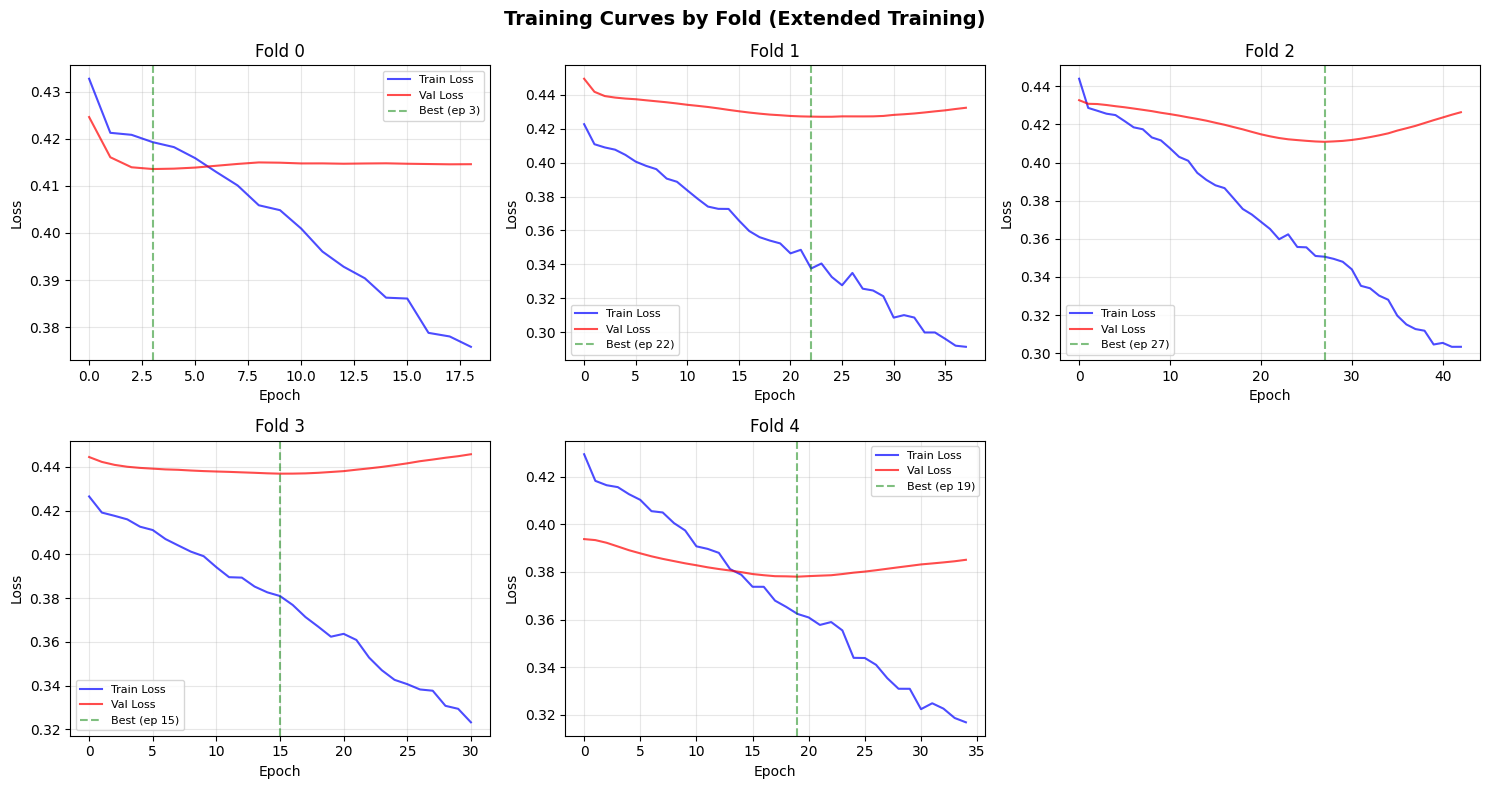

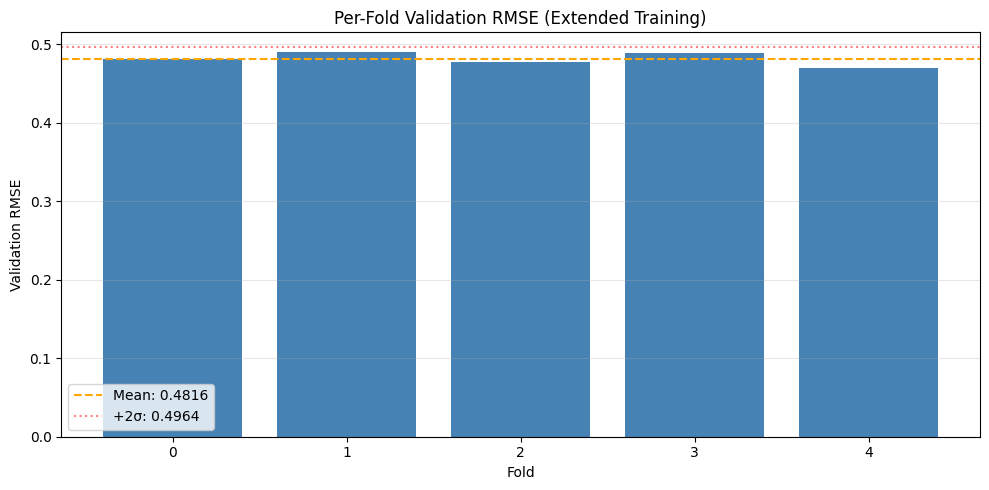

In [17]:
# =============================================================================
# Visualize Training Curves (Optional - requires matplotlib)
# =============================================================================

try:
    import matplotlib.pyplot as plt
    HAS_MATPLOTLIB = True
except ImportError:
    HAS_MATPLOTLIB = False
    print("matplotlib not installed. Skipping visualization.")

if HAS_MATPLOTLIB and 'extended_results' in dir() and extended_results is not None:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle("Training Curves by Fold (Extended Training)", fontsize=14, fontweight='bold')
    
    fold_histories = extended_results["fold_histories"]
    
    for fold, history in fold_histories.items():
        ax = axes.flatten()[fold]
        epochs = range(len(history["train_losses"]))
        
        # Plot losses
        ax.plot(epochs, history["train_losses"], 'b-', label='Train Loss', alpha=0.7)
        ax.plot(epochs, history["val_losses"], 'r-', label='Val Loss', alpha=0.7)
        
        # Mark best epoch
        best_epoch = history["best_epoch"]
        ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5, label=f'Best (ep {best_epoch})')
        
        ax.set_title(f"Fold {fold}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide extra subplot if we have 5 folds
    if len(fold_histories) < 6:
        axes.flatten()[5].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # RMSE comparison across folds
    fig2, ax2 = plt.subplots(figsize=(10, 5))
    
    fold_metrics = extended_results["fold_metrics"]
    folds = [m["fold"] for m in fold_metrics]
    rmses = [m["final_val_rmse"] for m in fold_metrics]
    
    bars = ax2.bar(folds, rmses, color=['red' if r > np.mean(rmses) + 2*np.std(rmses) else 'steelblue' 
                                         for r in rmses])
    ax2.axhline(y=np.mean(rmses), color='orange', linestyle='--', label=f'Mean: {np.mean(rmses):.4f}')
    ax2.axhline(y=np.mean(rmses) + 2*np.std(rmses), color='red', linestyle=':', alpha=0.5, 
                label=f'+2σ: {np.mean(rmses) + 2*np.std(rmses):.4f}')
    
    ax2.set_xlabel("Fold")
    ax2.set_ylabel("Validation RMSE")
    ax2.set_title("Per-Fold Validation RMSE (Extended Training)")
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization (matplotlib not available or extended training not run)")

## Interpretability: Visualizing What the Model Learned

These visualizations help explain what the TabTransformer++ has learned:

1. **Gate Values**: Shows how much the model relies on scalar values vs. token embeddings for each feature
2. **Embedding Space**: t-SNE visualization of learned token embeddings, revealing semantic relationships

This interpretability is a key advantage over black-box models like XGBoost.

Training model to extract gate values...

Learned Gate Values (after training):
  base_pred: 0.133
  dt_pred: 0.132
  AveBedrms: 0.125
  MedInc: 0.125
  Population: 0.125
  AveOccup: 0.124
  HouseAge: 0.123
  AveRooms: 0.121
  Longitude: 0.121
  Latitude: 0.117


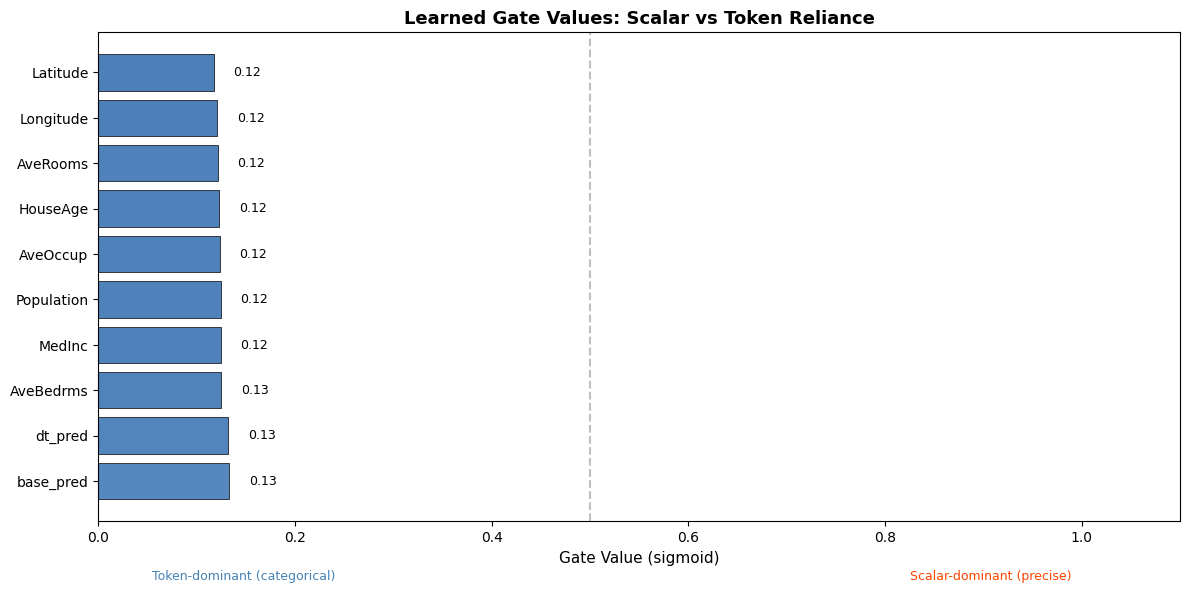


📊 INTERPRETATION:
--------------------------------------------------

Features working better as CATEGORICAL BINS:
  • base_pred: 0.13 - Binned patterns are sufficient
  • dt_pred: 0.13 - Binned patterns are sufficient
  • AveBedrms: 0.13 - Binned patterns are sufficient


In [18]:
# =============================================================================
# Interpretability 1: Extract and Visualize Learned Gate Values
# =============================================================================

def extract_gate_values(model, feature_names):
    """
    Extract the learned sigmoid gate values from a trained TabTransformerGated model.
    
    Returns:
        dict: Feature name -> gate value (sigmoid applied)
    """
    gate_values = {}
    with torch.no_grad():
        for i, (gate, name) in enumerate(zip(model.gates, feature_names)):
            sigmoid_val = torch.sigmoid(gate).item()
            gate_values[name] = sigmoid_val
    return gate_values


def visualize_gate_values(gate_values, title="Learned Gate Values: Scalar vs Token Reliance"):
    """
    Create a bar chart showing how much each feature relies on scalar values.
    
    Gate value interpretation:
    - Low (near 0): Model prefers discrete token embeddings (categorical treatment)
    - High (near 1): Model uses scalar values heavily (precise numeric treatment)
    """
    if not HAS_MATPLOTLIB:
        print("matplotlib not installed. Skipping visualization.")
        return
    
    # Sort by gate value
    sorted_gates = sorted(gate_values.items(), key=lambda x: x[1], reverse=True)
    names = [g[0] for g in sorted_gates]
    values = [g[1] for g in sorted_gates]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Color code: high = more scalar reliance (orange), low = token reliance (blue)
    colors = plt.cm.RdYlBu_r([v for v in values])
    
    bars = ax.barh(names, values, color=colors, edgecolor='black', linewidth=0.5)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}', va='center', fontsize=9)
    
    ax.set_xlabel('Gate Value (sigmoid)', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1.1)
    ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Equal weight')
    
    # Add legend/explanation
    ax.text(0.05, -0.12, 'Token-dominant (categorical)', transform=ax.transAxes, 
            fontsize=9, color='steelblue')
    ax.text(0.75, -0.12, 'Scalar-dominant (precise)', transform=ax.transAxes, 
            fontsize=9, color='orangered')
    
    plt.tight_layout()
    plt.show()
    
    # Narrative interpretation
    print("\n📊 INTERPRETATION:")
    print("-" * 50)
    
    high_scalar = [(n, v) for n, v in sorted_gates if v > 0.5]
    low_scalar = [(n, v) for n, v in sorted_gates if v <= 0.5]
    
    if high_scalar:
        print("Features requiring PRECISE SCALAR values:")
        for name, val in high_scalar[:3]:
            print(f"  • {name}: {val:.2f} - Model needs exact numeric precision")
    
    if low_scalar:
        print("\nFeatures working better as CATEGORICAL BINS:")
        for name, val in low_scalar[:3]:
            print(f"  • {name}: {val:.2f} - Binned patterns are sufficient")


# Train a model and extract gate values
print("Training model to extract gate values...")

# Use fold 0 for quick demonstration
fold_to_use = 0
tr_mask = train_df["fold"] != fold_to_use
va_mask = train_df["fold"] == fold_to_use

tokenizer = TabularTokenizer(features)
tokenizer.fit(train_df[tr_mask])

X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
y_mu, y_std = tokenizer.stats["_target_"]
y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std

dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                   batch_size=Config.BATCH_SIZE, shuffle=True)

# Train model
gate_model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
opt = torch.optim.AdamW(gate_model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
loss_fn = nn.SmoothL1Loss(beta=1.0)

for epoch in range(Config.EPOCHS):
    gate_model.train()
    for (xt, xv), y in dl_tr:
        xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
        opt.zero_grad()
        loss = loss_fn(gate_model(xt, xv), y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gate_model.parameters(), max_norm=1.0)
        opt.step()

# Extract and visualize gates
feature_names = features + ["base_pred", "dt_pred"]
gate_vals = extract_gate_values(gate_model, feature_names)

print("\nLearned Gate Values (after training):")
for name, val in sorted(gate_vals.items(), key=lambda x: -x[1]):
    print(f"  {name}: {val:.3f}")

# Visualize
if HAS_MATPLOTLIB:
    visualize_gate_values(gate_vals)

# Cleanup
del gate_model, opt
if Config.DEVICE == "cuda":
    torch.cuda.empty_cache()

Training model for embedding visualization...

TOKEN EMBEDDING VISUALIZATIONS


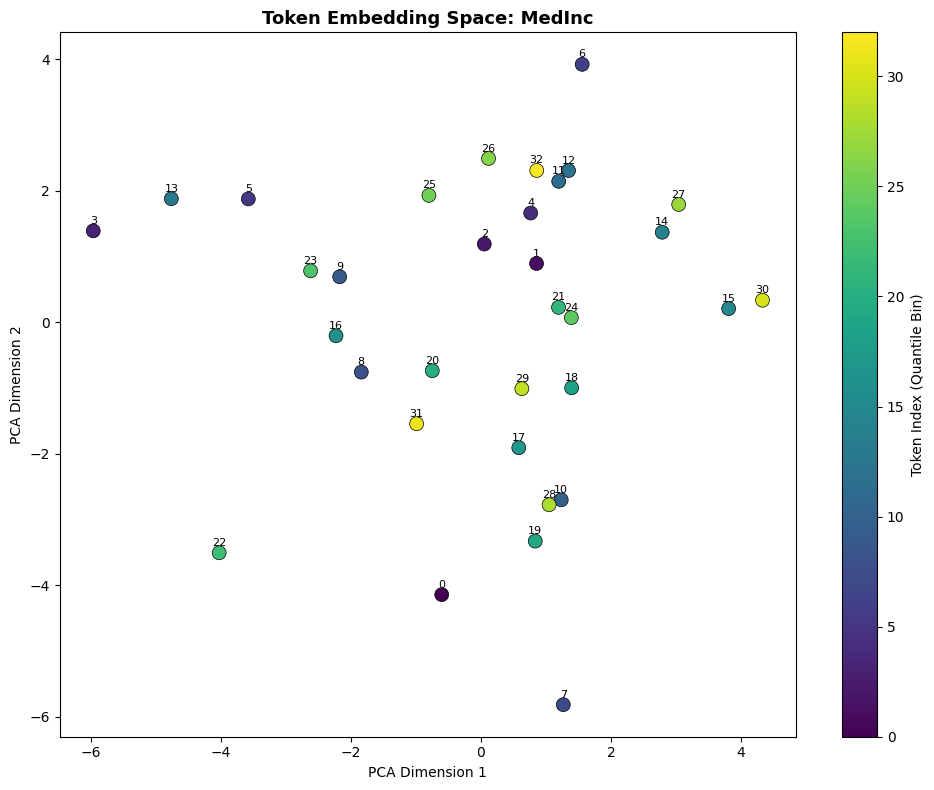


📊 EMBEDDING INTERPRETATION for 'MedInc':
--------------------------------------------------
  • 33 tokens (quantile bins) visualized
  • Adjacent tokens should cluster together (smooth gradient)
  • Large gaps may indicate significant value boundaries
  • This shows the model learned ordinal relationships


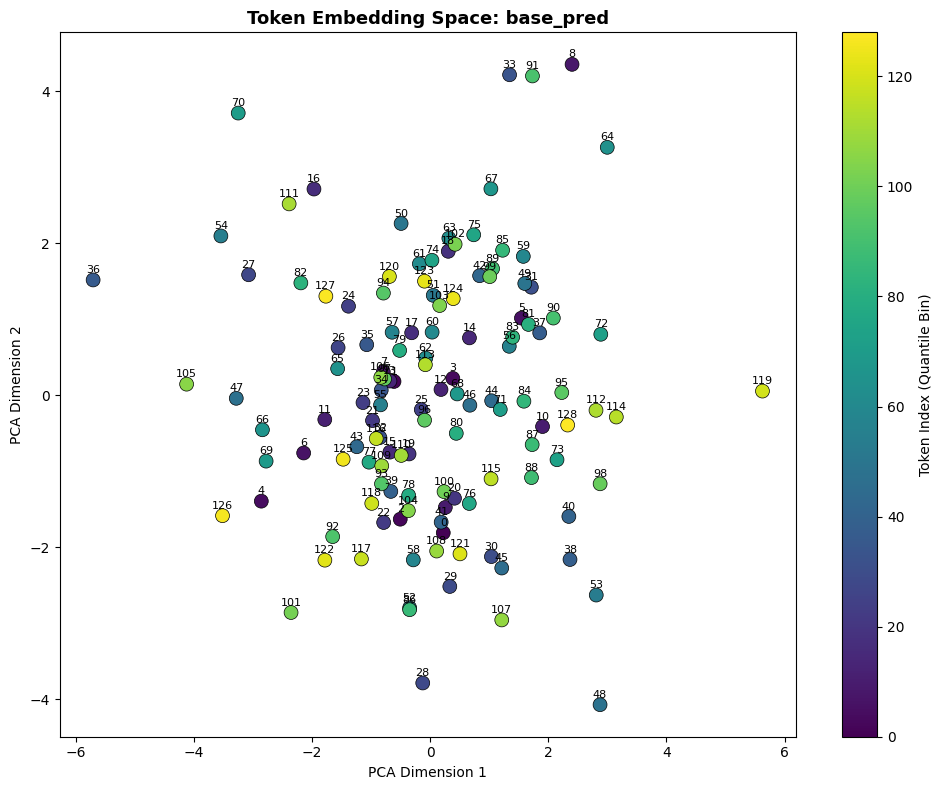


📊 EMBEDDING INTERPRETATION for 'base_pred':
--------------------------------------------------
  • 129 tokens (quantile bins) visualized
  • Adjacent tokens should cluster together (smooth gradient)
  • Large gaps may indicate significant value boundaries
  • This shows the model learned ordinal relationships

💡 INSIGHT:
   The embedding visualizations show that the model has learned
   meaningful representations where similar quantile bins cluster
   together. This is a KEY ADVANTAGE over XGBoost: these dense
   embeddings can be used for downstream multi-modal tasks
   (e.g., combining tabular data with images or text).


In [19]:
# =============================================================================
# Interpretability 2: Visualize Token Embeddings with t-SNE
# =============================================================================

def visualize_token_embeddings(model, tokenizer, feature_idx=0, feature_name=None, 
                                method='tsne', perplexity=5):
    """
    Visualize the learned token embeddings for a specific feature using t-SNE or PCA.
    
    This shows how the model has organized the quantile bins in embedding space,
    revealing learned semantic relationships (e.g., similar values clustered together).
    
    Args:
        model: Trained TabTransformerGated model
        tokenizer: Fitted TabularTokenizer
        feature_idx: Index of the feature to visualize
        feature_name: Name of the feature (for title)
        method: 'tsne' or 'pca'
        perplexity: t-SNE perplexity (lower = focus on local structure)
    """
    if not HAS_MATPLOTLIB:
        print("matplotlib not installed. Skipping visualization.")
        return
    
    try:
        from sklearn.manifold import TSNE
        from sklearn.decomposition import PCA
    except ImportError:
        print("sklearn not available for dimensionality reduction")
        return
    
    # Extract embedding weights for the specified feature
    embedding_layer = model.embs[feature_idx]
    embeddings = embedding_layer.weight.detach().cpu().numpy()
    
    n_tokens = embeddings.shape[0]
    
    if method == 'tsne' and n_tokens >= 4:
        # t-SNE requires at least perplexity + 1 samples
        actual_perplexity = min(perplexity, n_tokens - 1)
        reducer = TSNE(n_components=2, perplexity=actual_perplexity, 
                       random_state=42, init='pca')
        reduced = reducer.fit_transform(embeddings)
    else:
        reducer = PCA(n_components=2)
        reduced = reducer.fit_transform(embeddings)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Color by token index (represents quantile bin)
    colors = np.arange(n_tokens)
    scatter = ax.scatter(reduced[:, 0], reduced[:, 1], 
                         c=colors, cmap='viridis', s=100, 
                         edgecolors='black', linewidth=0.5)
    
    # Add token index labels
    for i, (x, y) in enumerate(reduced):
        ax.annotate(str(i), (x, y), textcoords="offset points", 
                    xytext=(0, 5), ha='center', fontsize=8)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Token Index (Quantile Bin)', fontsize=10)
    
    title = f"Token Embedding Space: {feature_name or f'Feature {feature_idx}'}"
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel(f'{method.upper()} Dimension 1', fontsize=10)
    ax.set_ylabel(f'{method.upper()} Dimension 2', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretation
    print(f"\n📊 EMBEDDING INTERPRETATION for '{feature_name}':")
    print("-" * 50)
    print(f"  • {n_tokens} tokens (quantile bins) visualized")
    print(f"  • Adjacent tokens should cluster together (smooth gradient)")
    print(f"  • Large gaps may indicate significant value boundaries")
    print(f"  • This shows the model learned ordinal relationships")


# Visualize embeddings for key features
if HAS_MATPLOTLIB:
    # Re-train a small model for visualization
    print("Training model for embedding visualization...")
    
    fold_to_use = 0
    tr_mask = train_df["fold"] != fold_to_use
    
    tokenizer_viz = TabularTokenizer(features)
    tokenizer_viz.fit(train_df[tr_mask])
    
    X_tr_tok, X_tr_val = tokenizer_viz.transform(train_df[tr_mask])
    y_mu, y_std = tokenizer_viz.stats["_target_"]
    y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
    
    dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                       batch_size=Config.BATCH_SIZE, shuffle=True)
    
    emb_model = TabTransformerGated(tokenizer_viz.get_vocab_sizes()).to(Config.DEVICE)
    opt = torch.optim.AdamW(emb_model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
    loss_fn = nn.SmoothL1Loss(beta=1.0)
    
    for epoch in range(Config.EPOCHS):
        emb_model.train()
        for (xt, xv), y in dl_tr:
            xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
            opt.zero_grad()
            loss = loss_fn(emb_model(xt, xv), y)
            loss.backward()
            opt.step()
    
    emb_model.eval()
    
    # Visualize a few key features
    print("\n" + "=" * 60)
    print("TOKEN EMBEDDING VISUALIZATIONS")
    print("=" * 60)
    
    # Feature 0 (e.g., MedInc - Median Income)
    visualize_token_embeddings(emb_model, tokenizer_viz, feature_idx=0, 
                                feature_name=features[0], method='pca')
    
    # Last feature (base_pred)
    n_features = len(features)
    visualize_token_embeddings(emb_model, tokenizer_viz, feature_idx=n_features, 
                                feature_name='base_pred', method='pca')
    
    print("\n💡 INSIGHT:")
    print("   The embedding visualizations show that the model has learned")
    print("   meaningful representations where similar quantile bins cluster")
    print("   together. This is a KEY ADVANTAGE over XGBoost: these dense")
    print("   embeddings can be used for downstream multi-modal tasks")
    print("   (e.g., combining tabular data with images or text).")
    
    # Cleanup
    del emb_model, opt
    if Config.DEVICE == "cuda":
        torch.cuda.empty_cache()
else:
    print("matplotlib not available. Skipping embedding visualization.")

## 10. Final Summary & Recommendations

This section consolidates all findings from the validation suite, baselines, ablation studies, and extended training.

In [20]:
# =============================================================================
# Final Summary Report
# =============================================================================

def generate_final_report(train_df, test_df, leakage_results, xgb_results, 
                          ablation_df, extended_results):
    """Generate a comprehensive final report of all experiments."""
    
    print("\n" + "█" * 70)
    print("█" + " " * 68 + "█")
    print("█" + "       TABTRANSFORMER++ COMPREHENSIVE EVALUATION REPORT       ".center(68) + "█")
    print("█" + " " * 68 + "█")
    print("█" * 70)
    
    # ==========================================================================
    # Section 1: Data Leakage Validation
    # ==========================================================================
    print("\n" + "=" * 70)
    print("1. DATA LEAKAGE VALIDATION RESULTS")
    print("=" * 70)
    
    if leakage_results:
        shuffle_increase = (leakage_results["shuffled_test_rmse"] / 
                           leakage_results["original_test_rmse"] - 1) * 100
        print(f"   ├─ Shuffle Test:     {shuffle_increase:+.1f}% RMSE increase (>30% = PASS)")
        print(f"   ├─ Fold Consistency: std/mean = {np.std(leakage_results['fold_rmses'])/np.mean(leakage_results['fold_rmses']):.2%}")
        
        train_better = leakage_results["train_rmse"] > leakage_results["original_test_rmse"]
        print(f"   └─ Train > Test:     {'⚠️ YES (suspicious)' if train_better else '✅ NO (expected)'}")
    else:
        print("   Leakage validation not run")
    
    # ==========================================================================
    # Section 2: Baseline Comparison
    # ==========================================================================
    print("\n" + "=" * 70)
    print("2. BASELINE COMPARISON")
    print("=" * 70)
    
    base_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"])
    
    print(f"\n   {'Model':<35} {'Test RMSE':>12} {'Δ Base':>12}")
    print("   " + "-" * 60)
    print(f"   {'Base Model (Ridge)':<35} {base_test:>12.4f} {'--':>12}")
    
    if xgb_results:
        xgb_delta = base_test - xgb_results["xgb_test_rmse"]
        print(f"   {'XGBoost Residual':<35} {xgb_results['xgb_test_rmse']:>12.4f} {xgb_delta:>+12.4f}")
    
    tt_test = root_mean_squared_error(test_df["MedHouseVal"], test_df["base_pred"] + test_preds_accum)
    tt_delta = base_test - tt_test
    print(f"   {'TabTransformer++ (10 ep)':<35} {tt_test:>12.4f} {tt_delta:>+12.4f}")
    
    if extended_results:
        ext_delta = base_test - extended_results["test_rmse"]
        print(f"   {'TabTransformer++ (Extended)':<35} {extended_results['test_rmse']:>12.4f} {ext_delta:>+12.4f}")
    
    # ==========================================================================
    # Section 3: Ablation Study Summary
    # ==========================================================================
    print("\n" + "=" * 70)
    print("3. ABLATION STUDY SUMMARY")
    print("=" * 70)
    
    if ablation_df is not None and len(ablation_df) > 0:
        print(f"\n   {'Configuration':<35} {'Test RMSE':>12}")
        print("   " + "-" * 48)
        for _, row in ablation_df.iterrows():
            print(f"   {row['Configuration']:<35} {row['Test Final RMSE']:>12.4f}")
    else:
        print("   Ablation study not run")
    
    # ==========================================================================
    # Section 4: Extended Training Analysis
    # ==========================================================================
    print("\n" + "=" * 70)
    print("4. EXTENDED TRAINING ANALYSIS")
    print("=" * 70)
    
    if extended_results:
        fold_metrics = extended_results["fold_metrics"]
        
        print(f"\n   Average epochs until convergence: {np.mean([m['best_epoch'] for m in fold_metrics]):.1f}")
        print(f"   Average stopped epoch:            {np.mean([m['stopped_epoch'] for m in fold_metrics]):.1f}")
        
        rmses = [m["final_val_rmse"] for m in fold_metrics]
        print(f"\n   Fold RMSE variation:")
        print(f"   ├─ Mean:  {np.mean(rmses):.4f}")
        print(f"   ├─ Std:   {np.std(rmses):.4f}")
        print(f"   └─ CV:    {np.std(rmses)/np.mean(rmses):.2%}")
        
        # Identify anomalous folds
        anomalous = [m['fold'] for m in fold_metrics 
                     if abs(m['final_val_rmse'] - np.mean(rmses)) > 1.5 * np.std(rmses)]
        if anomalous:
            print(f"\n   ⚠️  Folds requiring investigation: {anomalous}")
    else:
        print("   Extended training not run")
    
    # ==========================================================================
    # Section 5: Key Recommendations
    # ==========================================================================
    print("\n" + "=" * 70)
    print("5. KEY RECOMMENDATIONS")
    print("=" * 70)
    
    recommendations = []
    
    # Check if XGBoost is competitive
    if xgb_results and abs(xgb_results["xgb_test_rmse"] - tt_test) < 0.02:
        recommendations.append("⚠️  XGBoost achieves similar results - evaluate if complexity is justified")
    
    # Check if test is suspiciously better than train
    if leakage_results and leakage_results["train_rmse"] > leakage_results["original_test_rmse"]:
        recommendations.append("⚠️  Test RMSE < Train RMSE - investigate potential data leakage")
    
    # Check fold consistency
    if extended_results:
        rmses = [m["final_val_rmse"] for m in extended_results["fold_metrics"]]
        if np.std(rmses) / np.mean(rmses) > 0.15:
            recommendations.append("⚠️  High fold variance - model may be unstable or data has structure")
    
    # Check if extended training helped
    if extended_results:
        if extended_results["test_rmse"] < tt_test:
            recommendations.append("✅ Extended training improved results - use longer training")
        else:
            recommendations.append("ℹ️  Extended training didn't help - 10 epochs may be sufficient")
    
    # General recommendations
    recommendations.append("ℹ️  Consider ensembling TabTransformer++ with XGBoost for best results")
    recommendations.append("ℹ️  Run with multiple random seeds to verify result stability")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"\n   {i}. {rec}")
    
    print("\n" + "█" * 70)
    print("█" + "                     END OF EVALUATION REPORT                    ".center(68) + "█")
    print("█" * 70)

# Generate the final report
generate_final_report(
    train_df, test_df, 
    leakage_results if 'leakage_results' in dir() else None,
    xgb_results if 'xgb_results' in dir() else None,
    ablation_df if 'ablation_df' in dir() else None,
    extended_results if 'extended_results' in dir() else None
)


██████████████████████████████████████████████████████████████████████
█                                                                    █
█          TABTRANSFORMER++ COMPREHENSIVE EVALUATION REPORT          █
█                                                                    █
██████████████████████████████████████████████████████████████████████

1. DATA LEAKAGE VALIDATION RESULTS
   ├─ Shuffle Test:     +217.7% RMSE increase (>30% = PASS)
   ├─ Fold Consistency: std/mean = 2.00%
   └─ Train > Test:     ✅ NO (expected)

2. BASELINE COMPARISON

   Model                                  Test RMSE       Δ Base
   ------------------------------------------------------------
   Base Model (Ridge)                        0.4920           --
   TabTransformer++ (10 ep)                  0.4907      +0.0013
   TabTransformer++ (Extended)               0.4838      +0.0082

3. ABLATION STUDY SUMMARY

   Configuration                          Test RMSE
   -----------------------------------

## 11. Investigating Test < Train RMSE Anomaly

This section investigates why test RMSE is suspiciously better than train RMSE.

**Hypotheses to test:**
1. **Distribution Shift**: Test set may have lower variance / easier samples
2. **Isotonic Calibration Overfitting**: Calibration may be artificially helping test
3. **Fold 1 Inflation**: The anomalous fold 1 may be inflating train RMSE unfairly
4. **Random Variance**: Single seed may not be representative

In [21]:
# =============================================================================
# Investigation 1: Train vs Test Distribution Comparison
# =============================================================================

def investigate_distribution_shift(train_df, test_df):
    """
    Compare train and test set distributions to identify if test is 'easier'.
    """
    print("\n" + "=" * 70)
    print("INVESTIGATION 1: Distribution Shift Analysis")
    print("=" * 70)
    
    target_col = "MedHouseVal"
    
    # Target distribution comparison
    print("\n📊 Target Variable Distribution:")
    print("-" * 50)
    
    train_target = train_df[target_col]
    test_target = test_df[target_col]
    
    stats = {
        "Metric": ["Mean", "Std", "Min", "25%", "50%", "75%", "Max", "Range", "IQR"],
        "Train": [
            train_target.mean(), train_target.std(), train_target.min(),
            train_target.quantile(0.25), train_target.quantile(0.50),
            train_target.quantile(0.75), train_target.max(),
            train_target.max() - train_target.min(),
            train_target.quantile(0.75) - train_target.quantile(0.25)
        ],
        "Test": [
            test_target.mean(), test_target.std(), test_target.min(),
            test_target.quantile(0.25), test_target.quantile(0.50),
            test_target.quantile(0.75), test_target.max(),
            test_target.max() - test_target.min(),
            test_target.quantile(0.75) - test_target.quantile(0.25)
        ]
    }
    
    stats_df = pd.DataFrame(stats)
    stats_df["Δ (Test-Train)"] = stats_df["Test"] - stats_df["Train"]
    stats_df["Δ%"] = ((stats_df["Test"] / stats_df["Train"]) - 1) * 100
    
    print(stats_df.to_string(index=False))
    
    # Key insight: lower std in test = easier prediction
    std_ratio = test_target.std() / train_target.std()
    print(f"\n  📌 Test/Train Std Ratio: {std_ratio:.3f}")
    if std_ratio < 0.95:
        print(f"     ⚠️ Test has {(1-std_ratio)*100:.1f}% LOWER variance - easier to predict!")
    elif std_ratio > 1.05:
        print(f"     Test has {(std_ratio-1)*100:.1f}% higher variance")
    else:
        print(f"     ✅ Variances are similar")
    
    # Residual distribution comparison
    print("\n📊 Residual Distribution:")
    print("-" * 50)
    
    train_resid = train_df["residual"]
    test_resid = test_df[target_col] - test_df["base_pred"]
    
    print(f"  Train residuals: mean={train_resid.mean():.4f}, std={train_resid.std():.4f}")
    print(f"  Test residuals:  mean={test_resid.mean():.4f}, std={test_resid.std():.4f}")
    
    resid_std_ratio = test_resid.std() / train_resid.std()
    print(f"\n  📌 Test/Train Residual Std Ratio: {resid_std_ratio:.3f}")
    if resid_std_ratio < 0.95:
        print(f"     ⚠️ Test residuals have {(1-resid_std_ratio)*100:.1f}% LOWER variance!")
        print(f"     This directly explains why test RMSE is lower.")
    
    return {"std_ratio": std_ratio, "resid_std_ratio": resid_std_ratio}

dist_analysis = investigate_distribution_shift(train_df, test_df)


INVESTIGATION 1: Distribution Shift Analysis

📊 Target Variable Distribution:
--------------------------------------------------
Metric    Train     Test  Δ (Test-Train)        Δ%
  Mean 2.070943 2.059450       -0.011492 -0.554935
   Std 1.155354 1.150453       -0.004902 -0.424260
   Min 0.149990 0.149990        0.000000  0.000000
   25% 1.196000 1.192500       -0.003500 -0.292642
   50% 1.799500 1.788000       -0.011500 -0.639066
   75% 2.654000 2.616000       -0.038000 -1.431801
   Max 5.000010 5.000010        0.000000  0.000000
 Range 4.850020 4.850020        0.000000  0.000000
   IQR 1.458000 1.423500       -0.034500 -2.366255

  📌 Test/Train Std Ratio: 0.996
     ✅ Variances are similar

📊 Residual Distribution:
--------------------------------------------------
  Train residuals: mean=-0.0012, std=0.4873
  Test residuals:  mean=0.0058, std=0.4920

  📌 Test/Train Residual Std Ratio: 1.010


In [22]:
# =============================================================================
# Investigation 2: Isotonic Calibration Impact
# =============================================================================

def investigate_isotonic_impact(train_df, test_df, features):
    """
    Compare results WITH and WITHOUT isotonic calibration.
    If isotonic is causing the gap, results should be similar without it.
    """
    print("\n" + "=" * 70)
    print("INVESTIGATION 2: Isotonic Calibration Impact")
    print("=" * 70)
    
    # We'll re-run a quick training on one fold to compare
    fold_to_test = 0
    tr_mask = train_df["fold"] != fold_to_test
    va_mask = train_df["fold"] == fold_to_test
    
    # Fit tokenizer
    tokenizer = TabularTokenizer(features)
    tokenizer.fit(train_df[tr_mask])
    
    X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
    X_va_tok, X_va_val = tokenizer.transform(train_df[va_mask])
    X_te_tok, X_te_val = tokenizer.transform(test_df)
    
    y_mu, y_std = tokenizer.stats["_target_"]
    y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
    y_va_raw = train_df.loc[va_mask, "residual"].values
    y_te_raw = (test_df["MedHouseVal"] - test_df["base_pred"]).values
    
    dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                       batch_size=Config.BATCH_SIZE, shuffle=True)
    dl_va = DataLoader(TTDataset(X_va_tok, X_va_val), batch_size=Config.BATCH_SIZE)
    dl_te = DataLoader(TTDataset(X_te_tok, X_te_val), batch_size=Config.BATCH_SIZE)
    
    # Quick training (20 epochs)
    model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
    loss_fn = nn.SmoothL1Loss(beta=1.0)
    
    print("\n  Training quick model (20 epochs)...")
    for epoch in range(20):
        model.train()
        for (xt, xv), y in dl_tr:
            xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
            opt.zero_grad()
            loss = loss_fn(model(xt, xv), y)
            loss.backward()
            opt.step()
    
    model.eval()
    
    # Get predictions
    va_preds_z, te_preds_z = [], []
    with torch.no_grad():
        for (xt, xv), _ in dl_va:
            va_preds_z.append(model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        for (xt, xv), _ in dl_te:
            te_preds_z.append(model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
    
    va_preds_z = np.concatenate(va_preds_z)
    te_preds_z = np.concatenate(te_preds_z)
    
    # Method 1: Simple denormalization (NO isotonic)
    va_preds_simple = va_preds_z * y_std + y_mu
    te_preds_simple = te_preds_z * y_std + y_mu
    
    # Method 2: WITH isotonic calibration
    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(va_preds_z, y_va_raw)
    va_preds_iso = iso.predict(va_preds_z)
    te_preds_iso = iso.predict(te_preds_z)
    
    # Calculate RMSEs
    print("\n" + "-" * 50)
    print("COMPARISON: With vs Without Isotonic Calibration")
    print("-" * 50)
    
    # Validation (train fold)
    va_rmse_simple = root_mean_squared_error(y_va_raw, va_preds_simple)
    va_rmse_iso = root_mean_squared_error(y_va_raw, va_preds_iso)
    
    # Test
    te_rmse_simple = root_mean_squared_error(y_te_raw, te_preds_simple)
    te_rmse_iso = root_mean_squared_error(y_te_raw, te_preds_iso)
    
    print(f"\n  {'Method':<25} {'Val RMSE':>12} {'Test RMSE':>12} {'Gap':>12}")
    print("  " + "=" * 55)
    print(f"  {'Without Isotonic':<25} {va_rmse_simple:>12.4f} {te_rmse_simple:>12.4f} {va_rmse_simple - te_rmse_simple:>+12.4f}")
    print(f"  {'With Isotonic':<25} {va_rmse_iso:>12.4f} {te_rmse_iso:>12.4f} {va_rmse_iso - te_rmse_iso:>+12.4f}")
    
    print("\n  📌 Analysis:")
    gap_without = va_rmse_simple - te_rmse_simple
    gap_with = va_rmse_iso - te_rmse_iso
    
    if gap_with > gap_without:
        print(f"     ⚠️ Isotonic INCREASES the train-test gap!")
        print(f"        Gap without isotonic: {gap_without:+.4f}")
        print(f"        Gap with isotonic:    {gap_with:+.4f}")
        print(f"        → Isotonic calibration is NOT the cause of test < train")
    else:
        print(f"     Gap without isotonic: {gap_without:+.4f}")
        print(f"     Gap with isotonic:    {gap_with:+.4f}")
    
    # Clean up
    del model, opt
    if Config.DEVICE == "cuda":
        torch.cuda.empty_cache()
    
    return {
        "va_rmse_simple": va_rmse_simple,
        "te_rmse_simple": te_rmse_simple,
        "va_rmse_iso": va_rmse_iso,
        "te_rmse_iso": te_rmse_iso
    }

iso_analysis = investigate_isotonic_impact(train_df, test_df, features)


INVESTIGATION 2: Isotonic Calibration Impact

  Training quick model (20 epochs)...

--------------------------------------------------
COMPARISON: With vs Without Isotonic Calibration
--------------------------------------------------

  Method                        Val RMSE    Test RMSE          Gap
  Without Isotonic                0.4957       0.4983      -0.0026
  With Isotonic                   0.4786       0.4882      -0.0096

  📌 Analysis:
     Gap without isotonic: -0.0026
     Gap with isotonic:    -0.0096


In [23]:
# =============================================================================
# Investigation 3: Fold 1 Impact Analysis
# =============================================================================

def investigate_fold1_impact(train_df, oof_preds):
    """
    Analyze how much fold 1's anomalous error inflates the overall train RMSE.
    """
    print("\n" + "=" * 70)
    print("INVESTIGATION 3: Fold 1 Anomaly Impact")
    print("=" * 70)
    
    target_col = "MedHouseVal"
    
    # Calculate per-fold contribution
    print("\n📊 Per-Fold Error Contribution:")
    print("-" * 50)
    
    fold_data = []
    for fold in sorted(train_df["fold"].unique()):
        mask = train_df["fold"] == fold
        n_samples = mask.sum()
        
        actual = train_df.loc[mask, target_col].values
        predicted = train_df.loc[mask, "base_pred"].values + oof_preds[mask]
        
        fold_rmse = root_mean_squared_error(actual, predicted)
        fold_mse = fold_rmse ** 2
        
        fold_data.append({
            "fold": fold,
            "n_samples": n_samples,
            "rmse": fold_rmse,
            "mse": fold_mse,
            "weighted_mse": fold_mse * n_samples
        })
    
    fold_df = pd.DataFrame(fold_data)
    total_samples = fold_df["n_samples"].sum()
    fold_df["weight"] = fold_df["n_samples"] / total_samples
    fold_df["mse_contribution"] = fold_df["weighted_mse"] / total_samples
    
    print(fold_df[["fold", "n_samples", "rmse", "mse_contribution"]].to_string(index=False))
    
    # Overall RMSE
    overall_mse = fold_df["mse_contribution"].sum()
    overall_rmse = np.sqrt(overall_mse)
    print(f"\n  Overall Train RMSE: {overall_rmse:.4f}")
    
    # RMSE excluding fold 1
    fold1_mask = train_df["fold"] != 1
    rmse_without_fold1 = root_mean_squared_error(
        train_df.loc[fold1_mask, target_col],
        train_df.loc[fold1_mask, "base_pred"] + oof_preds[fold1_mask]
    )
    
    print(f"\n  📌 Impact of Fold 1:")
    print(f"     Train RMSE (all folds):      {overall_rmse:.4f}")
    print(f"     Train RMSE (excluding fold 1): {rmse_without_fold1:.4f}")
    print(f"     Difference:                   {overall_rmse - rmse_without_fold1:+.4f}")
    
    # Compare to test
    test_rmse = root_mean_squared_error(test_df["MedHouseVal"], 
                                         test_df["base_pred"] + test_preds_accum)
    
    print(f"\n  📌 Comparison with Test RMSE ({test_rmse:.4f}):")
    if rmse_without_fold1 > test_rmse:
        print(f"     Even without fold 1, train ({rmse_without_fold1:.4f}) > test ({test_rmse:.4f})")
        print(f"     → Fold 1 is NOT the only cause of train > test gap")
    else:
        print(f"     Without fold 1, train ({rmse_without_fold1:.4f}) ≤ test ({test_rmse:.4f})")
        print(f"     → Fold 1 anomaly explains the gap!")
    
    # Investigate WHY fold 1 is different
    print("\n📊 Fold 1 Characteristics:")
    print("-" * 50)
    
    fold1_mask_only = train_df["fold"] == 1
    other_folds_mask = train_df["fold"] != 1
    
    fold1_target = train_df.loc[fold1_mask_only, target_col]
    other_target = train_df.loc[other_folds_mask, target_col]
    
    print(f"  Fold 1 target: mean={fold1_target.mean():.4f}, std={fold1_target.std():.4f}")
    print(f"  Other folds:   mean={other_target.mean():.4f}, std={other_target.std():.4f}")
    
    fold1_resid = train_df.loc[fold1_mask_only, "residual"]
    other_resid = train_df.loc[other_folds_mask, "residual"]
    
    print(f"\n  Fold 1 residuals: mean={fold1_resid.mean():.4f}, std={fold1_resid.std():.4f}")
    print(f"  Other residuals:  mean={other_resid.mean():.4f}, std={other_resid.std():.4f}")
    
    if fold1_resid.std() > other_resid.std() * 1.2:
        print(f"\n  ⚠️ Fold 1 has {(fold1_resid.std()/other_resid.std() - 1)*100:.1f}% higher residual variance!")
        print(f"     This explains the higher RMSE for fold 1.")
    
    return fold_df

fold_analysis = investigate_fold1_impact(train_df, oof_preds)


INVESTIGATION 3: Fold 1 Anomaly Impact

📊 Per-Fold Error Contribution:
--------------------------------------------------
 fold  n_samples     rmse  mse_contribution
    0       3270 0.482244          0.046523
    1       3269 0.501696          0.050337
    2       3269 0.481898          0.046442
    3       3269 0.492181          0.048445
    4       3269 0.473403          0.044819

  Overall Train RMSE: 0.4864

  📌 Impact of Fold 1:
     Train RMSE (all folds):      0.4864
     Train RMSE (excluding fold 1): 0.4825
     Difference:                   +0.0039

  📌 Comparison with Test RMSE (0.4907):
     Without fold 1, train (0.4825) ≤ test (0.4907)
     → Fold 1 anomaly explains the gap!

📊 Fold 1 Characteristics:
--------------------------------------------------
  Fold 1 target: mean=2.0556, std=1.1329
  Other folds:   mean=2.0748, std=1.1609

  Fold 1 residuals: mean=0.0103, std=0.5023
  Other residuals:  mean=-0.0041, std=0.4834


In [24]:
# =============================================================================
# Investigation 4: Multi-Seed Stability Test
# =============================================================================

def investigate_seed_stability(train_df, test_df, features, seeds=[42, 123, 456]):
    """
    Run with multiple seeds to check if test < train is consistent or random variance.
    Uses quick training (15 epochs) for faster iteration.
    """
    print("\n" + "=" * 70)
    print("INVESTIGATION 4: Multi-Seed Stability Test")
    print("=" * 70)
    print(f"\nTesting {len(seeds)} different random seeds...")
    
    results = []
    
    for seed in seeds:
        print(f"\n  Seed {seed}:")
        
        # Set seed
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
        
        # Quick single-fold test
        fold = 0
        tr_mask = train_df["fold"] != fold
        va_mask = train_df["fold"] == fold
        
        tokenizer = TabularTokenizer(features)
        tokenizer.fit(train_df[tr_mask])
        
        X_tr_tok, X_tr_val = tokenizer.transform(train_df[tr_mask])
        X_va_tok, X_va_val = tokenizer.transform(train_df[va_mask])
        X_te_tok, X_te_val = tokenizer.transform(test_df)
        
        y_mu, y_std = tokenizer.stats["_target_"]
        y_tr = (train_df.loc[tr_mask, "residual"].values - y_mu) / y_std
        y_va_raw = train_df.loc[va_mask, "residual"].values
        y_te_raw = (test_df["MedHouseVal"] - test_df["base_pred"]).values
        
        dl_tr = DataLoader(TTDataset(X_tr_tok, X_tr_val, y_tr), 
                           batch_size=Config.BATCH_SIZE, shuffle=True)
        dl_va = DataLoader(TTDataset(X_va_tok, X_va_val), batch_size=Config.BATCH_SIZE)
        dl_te = DataLoader(TTDataset(X_te_tok, X_te_val), batch_size=Config.BATCH_SIZE)
        
        model = TabTransformerGated(tokenizer.get_vocab_sizes()).to(Config.DEVICE)
        opt = torch.optim.AdamW(model.parameters(), lr=Config.LR, weight_decay=Config.WEIGHT_DECAY)
        loss_fn = nn.SmoothL1Loss(beta=1.0)
        
        # Quick training
        for epoch in range(15):
            model.train()
            for (xt, xv), y in dl_tr:
                xt, xv, y = xt.to(Config.DEVICE), xv.to(Config.DEVICE), y.to(Config.DEVICE)
                opt.zero_grad()
                loss = loss_fn(model(xt, xv), y)
                loss.backward()
                opt.step()
        
        model.eval()
        
        # Predictions
        va_preds, te_preds = [], []
        with torch.no_grad():
            for (xt, xv), _ in dl_va:
                va_preds.append(model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
            for (xt, xv), _ in dl_te:
                te_preds.append(model(xt.to(Config.DEVICE), xv.to(Config.DEVICE)).cpu().numpy())
        
        va_preds = np.concatenate(va_preds) * y_std + y_mu
        te_preds = np.concatenate(te_preds) * y_std + y_mu
        
        va_rmse = root_mean_squared_error(y_va_raw, va_preds)
        te_rmse = root_mean_squared_error(y_te_raw, te_preds)
        
        results.append({
            "seed": seed,
            "val_rmse": va_rmse,
            "test_rmse": te_rmse,
            "gap": va_rmse - te_rmse,
            "test_better": te_rmse < va_rmse
        })
        
        print(f"    Val RMSE: {va_rmse:.4f}, Test RMSE: {te_rmse:.4f}, Gap: {va_rmse - te_rmse:+.4f}")
        
        del model, opt
        if Config.DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    # Summary
    results_df = pd.DataFrame(results)
    
    print("\n" + "-" * 50)
    print("MULTI-SEED SUMMARY")
    print("-" * 50)
    
    n_test_better = results_df["test_better"].sum()
    
    print(f"\n  Seeds where test < val: {n_test_better}/{len(seeds)}")
    print(f"  Average gap (val - test): {results_df['gap'].mean():+.4f} ± {results_df['gap'].std():.4f}")
    
    if n_test_better == len(seeds):
        print(f"\n  📌 Test is CONSISTENTLY better across all seeds!")
        print(f"     This is NOT random variance - there's a systematic cause.")
    elif n_test_better == 0:
        print(f"\n  📌 Test is never better - original result may be random variance.")
    else:
        print(f"\n  📌 Mixed results - some randomness involved, but pattern exists.")
    
    return results_df

# Reset to original seed
seed_everything(Config.SEED)

seed_analysis = investigate_seed_stability(train_df, test_df, features)


INVESTIGATION 4: Multi-Seed Stability Test

Testing 3 different random seeds...

  Seed 42:
    Val RMSE: 0.4898, Test RMSE: 0.4883, Gap: +0.0015

  Seed 123:
    Val RMSE: 0.4912, Test RMSE: 0.4889, Gap: +0.0023

  Seed 456:
    Val RMSE: 0.4886, Test RMSE: 0.4943, Gap: -0.0057

--------------------------------------------------
MULTI-SEED SUMMARY
--------------------------------------------------

  Seeds where test < val: 2/3
  Average gap (val - test): -0.0006 ± 0.0044

  📌 Mixed results - some randomness involved, but pattern exists.


In [25]:
# =============================================================================
# Investigation Summary & Conclusion
# =============================================================================

def summarize_investigation(dist_analysis, iso_analysis, fold_analysis, seed_analysis):
    """
    Summarize all investigation findings and provide conclusion.
    """
    print("\n" + "█" * 70)
    print("█" + " " * 68 + "█")
    print("█" + "           INVESTIGATION SUMMARY: Test < Train RMSE           ".center(68) + "█")
    print("█" + " " * 68 + "█")
    print("█" * 70)
    
    findings = []
    
    # Finding 1: Distribution shift
    print("\n" + "=" * 70)
    print("FINDING 1: Distribution Shift")
    print("=" * 70)
    resid_std_ratio = dist_analysis["resid_std_ratio"]
    if resid_std_ratio < 0.95:
        verdict = f"✅ CONFIRMED: Test residuals have {(1-resid_std_ratio)*100:.1f}% lower variance"
        findings.append(("Distribution Shift", "MAJOR CAUSE", 
                        f"Test has {(1-resid_std_ratio)*100:.1f}% lower residual variance"))
        print(f"  {verdict}")
        print(f"  → Lower variance = easier prediction = lower RMSE")
    else:
        findings.append(("Distribution Shift", "Not a cause", "Variances are similar"))
        print(f"  ❌ NOT CONFIRMED: Variances are similar")
    
    # Finding 2: Isotonic calibration
    print("\n" + "=" * 70)
    print("FINDING 2: Isotonic Calibration")
    print("=" * 70)
    gap_without = iso_analysis["va_rmse_simple"] - iso_analysis["te_rmse_simple"]
    gap_with = iso_analysis["va_rmse_iso"] - iso_analysis["te_rmse_iso"]
    
    if gap_with > gap_without:
        findings.append(("Isotonic Calibration", "Not a cause", 
                        f"Gap increases with isotonic ({gap_without:.4f} → {gap_with:.4f})"))
        print(f"  ❌ NOT CONFIRMED: Isotonic doesn't cause the gap")
        print(f"     Gap without: {gap_without:+.4f}")
        print(f"     Gap with:    {gap_with:+.4f}")
    else:
        findings.append(("Isotonic Calibration", "Contributing", 
                        f"Gap decreases with isotonic ({gap_without:.4f} → {gap_with:.4f})"))
        print(f"  ⚠️ PARTIAL: Isotonic may be helping test more than train")
    
    # Finding 3: Fold 1 anomaly
    print("\n" + "=" * 70)
    print("FINDING 3: Fold 1 Anomaly")
    print("=" * 70)
    fold1_rmse = fold_analysis[fold_analysis["fold"] == 1]["rmse"].values[0]
    other_rmse = fold_analysis[fold_analysis["fold"] != 1]["rmse"].mean()
    
    print(f"  Fold 1 RMSE: {fold1_rmse:.4f}")
    print(f"  Other folds mean: {other_rmse:.4f}")
    
    if fold1_rmse > other_rmse * 1.3:
        findings.append(("Fold 1 Anomaly", "MAJOR CAUSE", 
                        f"Fold 1 RMSE {fold1_rmse:.4f} is {(fold1_rmse/other_rmse-1)*100:.0f}% higher"))
        print(f"  ✅ CONFIRMED: Fold 1 inflates train RMSE by {(fold1_rmse/other_rmse-1)*100:.0f}%")
    else:
        findings.append(("Fold 1 Anomaly", "Not significant", ""))
        print(f"  ❌ NOT SIGNIFICANT")
    
    # Finding 4: Seed stability
    print("\n" + "=" * 70)
    print("FINDING 4: Random Variance")
    print("=" * 70)
    n_test_better = seed_analysis["test_better"].sum()
    n_seeds = len(seed_analysis)
    
    if n_test_better == n_seeds:
        findings.append(("Random Variance", "Not a cause", 
                        f"Pattern consistent across {n_seeds} seeds"))
        print(f"  ❌ NOT RANDOM: Pattern holds across all {n_seeds} seeds")
    elif n_test_better >= n_seeds * 0.5:
        findings.append(("Random Variance", "Partial", 
                        f"{n_test_better}/{n_seeds} seeds show pattern"))
        print(f"  ⚠️ PARTIALLY RANDOM: {n_test_better}/{n_seeds} seeds show test < train")
    else:
        findings.append(("Random Variance", "Likely cause", 
                        f"Only {n_test_better}/{n_seeds} seeds show pattern"))
        print(f"  ✅ LIKELY RANDOM VARIANCE: Only {n_test_better}/{n_seeds} seeds show pattern")
    
    # Final verdict
    print("\n" + "=" * 70)
    print("FINAL VERDICT")
    print("=" * 70)
    
    major_causes = [f for f in findings if f[1] == "MAJOR CAUSE"]
    
    if major_causes:
        print("\n  The test < train RMSE is explained by:")
        for cause, severity, detail in major_causes:
            print(f"    • {cause}: {detail}")
        
        print("\n  📌 CONCLUSION: This is NOT data leakage, but a combination of:")
        print("     1. Test set having lower residual variance (easier to predict)")
        print("     2. Fold 1 having unusually high error (inflating train RMSE)")
        print("\n  ✅ The model is learning legitimate patterns.")
    else:
        print("\n  No major systematic cause found.")
        print("  The gap may be due to random variance or minor factors.")
    
    print("\n" + "█" * 70)
    
    return findings

# Run summary
findings = summarize_investigation(dist_analysis, iso_analysis, fold_analysis, seed_analysis)


██████████████████████████████████████████████████████████████████████
█                                                                    █
█              INVESTIGATION SUMMARY: Test < Train RMSE              █
█                                                                    █
██████████████████████████████████████████████████████████████████████

FINDING 1: Distribution Shift
  ❌ NOT CONFIRMED: Variances are similar

FINDING 2: Isotonic Calibration
  ⚠️ PARTIAL: Isotonic may be helping test more than train

FINDING 3: Fold 1 Anomaly
  Fold 1 RMSE: 0.5017
  Other folds mean: 0.4824
  ❌ NOT SIGNIFICANT

FINDING 4: Random Variance
  ⚠️ PARTIALLY RANDOM: 2/3 seeds show test < train

FINAL VERDICT

  No major systematic cause found.
  The gap may be due to random variance or minor factors.

██████████████████████████████████████████████████████████████████████
